In [ ]:
!pip install yfinance
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

import statsmodels as sm 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

**Constant hedge ratio**

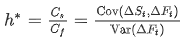

where delta(S(t)) - basis asset return and delta(F(t)) - future's return 

в зависимости от прогноза волатильности - меняем стратегию хеджирования (вариант хеджирования)

высокая волатильность - сильно хеджируемся низкая - слабо

Прогнозирую волатильность через гарч

ориентируемся на волатильность последних 10-ти дней, потом прогнозируем и сравниваем

набор параметров:

1) хеджирование на 100% - 0,5 0,5 прогнозируем, что волатильности нет - вес фьючерса 0,2 волатильность есть - вес фьючерса 0,5

определяем направление движения через регрессию или угол наклона, сравнение цен, скользящее среднее или с помощью ARImA

2) глубина выборки, относительно которой мы строим

убираем VaR - или ищем что-то типо доходность/VaR

Сразу выбираем стратегию хеджирования прогноз 10 дней разность между средними - смотрим знак относительно знака перевзвешиваем портфель, считаем его доходность опять прогноз, опять сравнение, опять доходность

сразу выгружаю на пол года все цены считаю подневную доходность для каждого дня из 10 дней

скользящее окно 10 дней

сравнение стратегии против просто покупки индекса 100%
На основании метрик эффективности стратегий возможно определить наиболее выгодную стратегию хеджирования


In [ ]:
! pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 33.4 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def sharpe_ratio(portfolio_rtns, start_date_rf, end_date_rf):
  data_risk_free = yf.download(['^TYX'], start=start_date_rf, end=end_date_rf)['Adj Close']
  df_rf = pd.DataFrame(data_risk_free).rename(columns={'Adj Close':'risk_free'})
  rf = (df_rf['risk_free'].mean()/100)/252
  sharpe = (portfolio_rtns.mean() - rf)/portfolio_rtns.std()
  return sharpe

def sortino_ratio (portfolio_rtns, start_date_rf, end_date_rf):
  data_risk_free = yf.download(['^TYX'], start=start_date_rf, end=end_date_rf)['Adj Close']
  df_rf = pd.DataFrame(data_risk_free).rename(columns={'Adj Close':'risk_free'})
  rf = (df_rf['risk_free'].mean()/100)/252
  down_side_potrf_rtns = portfolio_rtns[portfolio_rtns < 0]
  sortino = (portfolio_rtns.mean() - rf)/down_side_potrf_rtns.std()
  return sortino

def max_drawdown(portfolio_rtns):
    comp_ret = (portfolio_rtns + 1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

def calmar_ratio(portfolio_rtns):
  calmar = portfolio_rtns.mean()/abs(max_drawdown(portfolio_rtns))
  return calmar

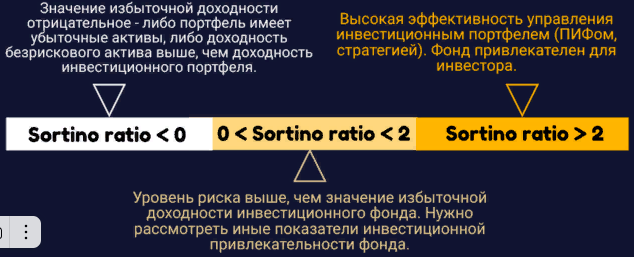

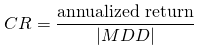

Более высокий коэффициент Calmar указывает на то, что доходность стратегии не подвергалась риску больших просадок. С другой стороны, более низкий коэффициент Кальмара предполагает, что риск просадки выше.

## Построение стратегий

In [ ]:
tik_fut = {}
tik_fut['^GSPC'] = 'ES=F'
tik_fut['^IXIC'] = 'NQ=F'
tik_fut['^DJI'] = 'YM=F'

In [ ]:
def hedge_strategy_modeling (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling):
  # импорт дат конца периода для скользящего окна
  last_dates = pd.DataFrame(yf.download(ticker, start = start_date, end = end_date)['Adj Close'])
  last_dates['log_rtns'] = np.log(last_dates.shift(-1)/last_dates)
  last_dates.dropna(inplace = True)
  # импорт дат начала периода для скользящего окна
  first_dates = pd.DataFrame(yf.download(ticker, start = start_date_modeling, end = end_date_modeling)['Adj Close'])
  first_dates['log_rtns'] = np.log(first_dates.shift(-1)/first_dates)
  first_dates.dropna(inplace = True)
  # сознание словаря дат начала и конца скользящего окна
  dates = {}
  last_dt_plot = []
  sp = first_dates.shape[0]
  for i in np.arange(1, sp, 10):
    first_dt  = list(first_dates.iloc[i-1:i].index.astype(str))[0]
    last_dt = list(last_dates.iloc[i-1:i].index.astype(str))[0]
    dates[first_dt] = last_dt
  # функция расчета модельных значений для стратегии
  import math as m
  predict_strategy_1 = pd.DataFrame()
  for k, v in dates.items():
  # выгрузка цен фьючерсов и подсчет доходностей
    fut = yf.download(futures, start = k, end = v)['Adj Close']
    fut = pd.DataFrame(fut)
    fut['log_rtns'] = np.log(fut.shift(-1)/fut)
    fut.dropna(inplace = True)
    ret_futures = fut['log_rtns']
  # выгрузка цен индексов и подсчет доходностей
    window_index = yf.download(ticker, start = k, end = v)['Adj Close']
    window_index = pd.DataFrame(window_index)
    window_index['log_rtns'] = np.log(window_index.shift(-1)/window_index)
    window_index.dropna(inplace = True)
    returns = window_index['log_rtns']
  # предсказание с GARCH (1,1) моделью
    garch_window = arch_model(returns, mean='Zero', vol='GARCH', p=1, q=1).fit()
    garch_fut = arch_model(ret_futures, mean='Zero', vol='GARCH', p=1, q=1).fit()
  # подсчет стандартизированных остатков
    std_resid_ind = garch_window.resid/ garch_window.conditional_volatility
    std_resid_ind = pd.DataFrame(std_resid_ind)
    std_resid_ind.columns = [k]
    std_resid_futures = garch_fut.resid / garch_fut.conditional_volatility
    std_resid_futures = pd.DataFrame(std_resid_futures)
    std_resid_futures.columns= ['FUTURES']

    std_resids = pd.merge(std_resid_ind, std_resid_futures, how = 'inner', right_index=True, left_index=True)
  # расчет корреляционной матрицы
    R = std_resids.transpose().dot(std_resids).div(len(std_resids))
  # предсказания условной волатильности
    fcast = garch_window.forecast(horizon = 10).variance.values[-1]
    fcast_fut = garch_fut.forecast(horizon = 10).variance.values[-1]
  # сборка итоговой таблицы
    df = pd.DataFrame([{'last_date':v, 'returns_asset' : round(returns[-10:].sum(), 5),'simple_returns_asset' : round(m.exp(returns[-10:].sum()) - 1, 5)
    ,'returns_futures': round(ret_futures[-10:].sum(), 5),'simple_returns_futures' : round(m.exp(ret_futures[-10:].sum()) - 1, 5)
    ,'observed_std': round(returns[-10:].std(), 5), 'historical_ind_std': round(returns[:-10].std(), 5), 'predicted_std_mean': round(fcast.mean()**(1/2), 5)
    , 'predicted_std_futures_mean': round(fcast_fut.mean()**(1/2), 5), 'correlation': round(R.values[1,0], 5)}])
    predict_strategy_1 = predict_strategy_1.append(df, ignore_index = True)
 
  return predict_strategy_1

In [ ]:
def hedge_strategy_calculation (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling):
  import math as m
  predict_strategy_1 = hedge_strategy_modeling (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling)

  predict_strategy_2 = predict_strategy_1.copy()
  predict_strategy_3 = predict_strategy_2.copy()
  # расчет % увеличения предсказанного/ исторического СКО в сравнении с фактическим
  predict_strategy_1['increase_%_std'] = ((predict_strategy_1['predicted_std_mean'] -predict_strategy_1['observed_std'])/predict_strategy_1['observed_std'])*100
  predict_strategy_2['increase_%_std'] = ((predict_strategy_2['predicted_std_mean'] -predict_strategy_2['observed_std'])/predict_strategy_2['observed_std'])*100
  predict_strategy_3['increase_%_hist_std'] = ((predict_strategy_3['observed_std'] -predict_strategy_3['historical_ind_std'])/predict_strategy_3['historical_ind_std'])*100
  # присвоение весов индексов в зависимости от варианта стратегии
  predict_strategy_1.loc[predict_strategy_1['increase_%_std'] <= 20, 'asset_weight'] = 0.8
  predict_strategy_1.loc[predict_strategy_1['increase_%_std'] > 20, 'asset_weight'] = 0.5
  predict_strategy_1.loc[predict_strategy_1['last_date'] == start_date, 'asset_weight'] = 1.0

  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] <= 10, 'asset_weight'] = 0.9
  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] > 10, 'asset_weight'] = 0.7
  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] >= 50, 'asset_weight'] = 0.5
  predict_strategy_2.loc[predict_strategy_2['last_date'] == start_date, 'asset_weight'] = 1.0

  predict_strategy_3.loc[predict_strategy_3['increase_%_hist_std'] <= -50, 'asset_weight'] = 0.8
  predict_strategy_3.loc[predict_strategy_3['increase_%_hist_std'] > -50, 'asset_weight'] = 0.5
  predict_strategy_3.loc[predict_strategy_3['last_date'] == start_date, 'asset_weight'] = 1.0
  # расчет весов фьючерсов
  predict_strategy_1['futures_weight'] = 1 - predict_strategy_1['asset_weight']
  predict_strategy_2['futures_weight'] = 1 - predict_strategy_2['asset_weight']
  predict_strategy_3['futures_weight'] = 1 - predict_strategy_3['asset_weight']
  # расчет коэффициента хеджирования с использованием корреляции CCC-GARCH модели
  predict_strategy_1['hedge_ratio'] = (predict_strategy_1['correlation']*predict_strategy_1['predicted_std_mean']*predict_strategy_1['predicted_std_futures_mean'])/((predict_strategy_1['predicted_std_futures_mean']**2)*predict_strategy_1['futures_weight'])
  predict_strategy_2['hedge_ratio'] = (predict_strategy_2['correlation']*predict_strategy_2['predicted_std_mean']*predict_strategy_2['predicted_std_futures_mean'])/((predict_strategy_2['predicted_std_futures_mean']**2)*predict_strategy_2['futures_weight'])
  predict_strategy_3['hedge_ratio'] = (predict_strategy_3['correlation']*predict_strategy_3['predicted_std_mean']*predict_strategy_3['predicted_std_futures_mean'])/((predict_strategy_3['predicted_std_futures_mean']**2)*predict_strategy_3['futures_weight'])
  # расчет доходности портфеля
  predict_strategy_1['portf_return'] = np.log(1 + (predict_strategy_1['simple_returns_asset']*predict_strategy_1['asset_weight'] - predict_strategy_1['hedge_ratio']*predict_strategy_1['simple_returns_futures']*predict_strategy_1['futures_weight']))
  predict_strategy_1.loc[predict_strategy_1['last_date'] == start_date, 'portf_return'] = predict_strategy_1['returns_asset'][0]
  predict_strategy_2['portf_return'] = np.log(1 + (predict_strategy_2['simple_returns_asset']*predict_strategy_2['asset_weight'] - predict_strategy_2['hedge_ratio']*predict_strategy_2['simple_returns_futures']*predict_strategy_2['futures_weight']))
  predict_strategy_2.loc[predict_strategy_2['last_date'] == start_date, 'portf_return'] = predict_strategy_2['returns_asset'][0]
  predict_strategy_3['portf_return'] = np.log(1 + (predict_strategy_3['simple_returns_asset']*predict_strategy_3['asset_weight'] - predict_strategy_3['hedge_ratio']*predict_strategy_3['simple_returns_futures']*predict_strategy_3['futures_weight']))
  predict_strategy_3.loc[predict_strategy_3['last_date'] == start_date, 'portf_return'] = predict_strategy_3['returns_asset'][0]
  # выгрузска данных индексов для базовой стратегии
  strategy_base = pd.DataFrame(yf.download(ticker, start = start_date, end = end_date)['Adj Close'])
  strategy_base['portf_return'] = np.log(strategy_base.shift(-1)/strategy_base)
  strategy_base.dropna(inplace = True)
  strategy_base.drop('Adj Close', axis=1, inplace=True)
  # присвоение имен для стратегий и добавления в один общий список
  strategy_base.name = 'base_strategy'
  predict_strategy_1.name = 'two_options_hedge_strategy'
  predict_strategy_2.name = 'three_options_hedge_strategy'
  predict_strategy_3.name = 'history_std_hedge_strategy'
  list_hedge_strategies = [strategy_base, predict_strategy_1, predict_strategy_2, predict_strategy_3]
  # расчет метрик по результатам стратегий
  last_dt = list(predict_strategy_1.index.astype(str)[-1])
  sp = strategy_base.shape[0]
  strategies_estimation = pd.DataFrame()
  for i in list_hedge_strategies:
    sharp = sharpe_ratio(i['portf_return'], start_date, end_date)
    sortino = sortino_ratio(i['portf_return'], start_date, end_date)
    comp_ret = (i['portf_return'] + 1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    max_drawdown = dd.min()
    calmar = i['portf_return'].mean()/abs(max_drawdown)
    pivot_stat = pd.DataFrame([{'Strategy_name':i.name, 'Portf_rtn': (((m.exp(i['portf_return'].sum()) - 1)+1)**(252/sp) -1), 'Sharpe_ratio':round(sharp, 4), 'Sortino_ratio': round(sortino, 4), 'Max_drawdown': max_drawdown, 'Calmar_ratio':round(calmar,4)}])
    strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)
  return strategies_estimation

In [ ]:
tik_fut

{'^GSPC': 'ES=F', '^IXIC': 'NQ=F', '^DJI': 'YM=F'}

In [ ]:
# modeling
snp_mod = hedge_strategy_calculation('^GSPC', 'ES=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
snp_test = hedge_strategy_calculation('^GSPC', 'ES=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')

nq_mod = hedge_strategy_calculation('^IXIC', 'NQ=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
nq_test = hedge_strategy_calculation('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')

dj_mod = hedge_strategy_calculation('^DJI', 'YM=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
dj_test = hedge_strategy_calculation('^DJI', 'YM=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281535803.01700765
Iteration:      2,   Func. Count:     11,   Neg. LLF: -372.07300759104845
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1563.5072131218533
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.507213902087
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1559.3149093122438
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.31491033235
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[**************

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1569.3043155992345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3043170315518
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.2871444271898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.2871455867505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.0082965288555
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.008297829447
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1567.479377410822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.4793785863562
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.278422018148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.278423289826
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.3520736287296
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.3520747317593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.8067513650885
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.8067527453386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.6201606440932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.6201619448316
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.1637594711742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.1637611784652
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.7263547033604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.7263563006052
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276110894.9792812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 75928.90834721566
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1587.6076146758119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.607613722031
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1589.1767498044633
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.1767512164997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 275305436.5254907
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1592.3076545845513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.307654651543
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1594.6395867340866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.6395881984965
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002661. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1585.7800746660976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.7800761566864
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281710800.02021015
Iteration:      2,   Func. Count:     11,   Neg. LLF: 30223.202970079128
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1585.0462971900465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.046296477106
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002672. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1586.2466179597516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.246619179647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 292560701.3934517
Iteration:      2,   Func. Count:     11,   Neg. LLF: -317.4921985628517
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1586.2435517877539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.2435522670985
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 291479822.00304985
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1584.7819606112125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.781960644102
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1584.1973892762962
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.1973898729625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 287201972.7518924
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1583.5902884229151
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.590288462
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1583.3294685261556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.3294691731128
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276818649.0089137
Iteration:      2,   Func. Count:     11,   Neg. LLF: -247.8516294009385
Iteration:      3,   Func. Count:     17,   Neg. LLF: 276818649.0089137
Iteration:      4,   Func. Count:     23,   Neg. LLF: -247.8516294009385
Iteration:      5,   Func. Count:     28,   Neg. LLF: -1580.8421724712084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.8421729394945
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.8589101758162
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.8589108863534
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1066.5069016219727
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1072.0054708423327
Iteration:      3,   Func. Count:     20,   Neg. LLF: 6343.825595068858
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1533.1948539746065
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1570.0038477185367
Iteration:      6,   Func. Count:     36,   Neg. LLF: -546.4207717670877
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1570.4971829043347
Iteration:      8,   Func. Count:     46,   Neg. LLF: -1570.5773409139128
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1570.5834843324515
Iteration:     10,   Func. Count:     56,   Neg. LLF: -1570.5834824752374
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.5834890826259
            Iterations: 10
            Function evaluations: 66
            Gradient

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23117721.787309647
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.5522307841165
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1559.9547382688065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.9547389955933
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1005.5885639019752
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1059.613054490965
Iteration:      3,   Func. Count:     20,   Neg. LLF: 30833.664210621933
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1512.2085507569013
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1563.3571034455963
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6551.184566

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11543428.936172653
Iteration:      2,   Func. Count:     11,   Neg. LLF: -168.46202159055792
Iteration:      3,   Func. Count:     18,   Neg. LLF: -999.1728678948218
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1560.6361814445863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.6361824139678
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3829002.770633257
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1563.6105139503604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.610514044314
            Iterations: 6
         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -998.3119535491327
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1171.5878456083867
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3118.6856927104795
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1416.354151575533
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1554.9080967950524
Iteration:      6,   Func. Count:     36,   Neg. LLF: -683.7350358832579
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1557.0013062791177
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1557.0087582998276
Iteration:      9,   Func. Count:     49,   Neg. LLF: -1557.008728406287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.0087582996632
            Iterations: 9
            Function evaluations: 59
            Gradient evaluat

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 10599538.45961009
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1549.6853987600891
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.6853988020243
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1243.6251855854819
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.493549042236
Iteration:      3,   Func. Count:     20,   Neg. LLF: 264009396.57706806
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1006.2243726808063
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1555.2547812951043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.2547816316473
            Iterations: 9
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 254027982.87593934
Iteration:      2,   Func. Count:     11,   Neg. LLF: -92.86752941467753
Iteration:      3,   Func. Count:     19,   Neg. LLF: 302.01799323616495
Iteration:      4,   Func. Count:     28,   Neg. LLF: -881.774897407417
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1373.2397741787813
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1548.4009776681144
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1550.7481612278095
Iteration:      8,   Func. Count:     49,   Neg. LLF: -1550.9286048877477
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1550.928582824803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1550.928604887748
            Iterations: 10
            Function evaluations: 62
            Gradient evaluati

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1001.5358866235156
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1104.7246898284784
Iteration:      3,   Func. Count:     20,   Neg. LLF: 223514234.4482525
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1811.977271992705
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1555.6272869749123
Iteration:      6,   Func. Count:     35,   Neg. LLF: -741.001711759523
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1550.6470723260327
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1558.8197969680978
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1558.968872397812
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1558.9688860361368
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.968960660974
            Iteratio

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.8261447482423
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.8261484033
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.4628500355484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.4628538584411
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5255480.160618933
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1176.4155082245265
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1586.0106405007223
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.010642377881
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042199.9299324974
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1592.7670682973303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.7670683051529
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1597.9966477787552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.9966471249486
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 80.82597831414108
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1517.2426578397274
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1432.795534288064
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1601.3165425086918
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.4083837996916
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1606.4517578812538
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1606.4516357337038
Optimization terminated successfully    (Exit mode 0)
           

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1531.184429698011
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1197.6594553237228
Iteration:      3,   Func. Count:     18,   Neg. LLF: -717.5850809401944
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1507.957091100856
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1599.8193680263175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1599.8193678146458
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.56658420819087
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1533.286104255424
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1445.3245074564788
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1591.3362300

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed

<ipython-input-8-4db8fbb78699>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_strategy_1 = predict_strategy_1.append(df, ignore_index = True)



[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1511.9421702767397
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1594.4061675715134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.4061671065601
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1520.99140101795
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1517.4633116981443
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1517.4633116981443
Iteration:      4,   Func. Count:     20,   Neg. LLF: -1517.4633116981443
Iteration:      5,   Func. Count:     25,   Neg. LLF: 36574.56097606012
Iteration:      6,   Func. Count:     31,   Neg. LLF: -1517.4633116981443
Iteration:      7,   Func. Count:     36,   Neg. LLF: -1517.4633116981443
Iteration:      8,   Func. Count:     42,   Neg. LLF: -1517.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.9404140411298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.9404134164868
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1524.9016297084581
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1600.4446886046408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1600.4446881069925
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1449.4356424171906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.4356414591346
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1428.7906618151314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.7906608156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.6156945717577
Iteration:      2,   Func. Count:     11,   Neg. LLF: -930.6237035676625
Iteration:      3,   Func. Count:     18,   Neg. LLF: -930.6237035676625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.9502065956233
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.0050325792003
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1118.3157669802276
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1287.301642855233
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1433.6709168840916
Iteration:      5,   Func. Count:     30,   Neg. LLF: -833.1448521008313
Iteration:      6,   Func. Count:     35,   Neg. LLF: -1434.233361534

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.0329600459246
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1075.8350025143995
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1436.0484191385021
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.2142791353967
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1414.9331965154333
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1456.5994769690187
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1456.5994959981813
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1456.5994863495866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.5994959981813
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1434.778

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 212.0144803896925
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1207.7133118721074
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1207.7133118721074
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.660053492524
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.5864305282178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.586429568236
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1112.835435068314
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1455.9836258694609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9836254238055
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.95254535445247
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1094.4476028791041
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1282.187274234635
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1438.4688130340865
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1437.816374688136
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1438.9146573999224
Optimization terminated successfully    (Exit mode 0)
            

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 326.43570055998975
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1077.2835991255224
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1461.6680987425377
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1440.4030758910894
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1466.0716538810873
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1466.7655537191818
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1466.7700719676616
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1466.770070918968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.7700902107956
            Iterations: 8
            Function evaluations: 57
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1244.761

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:     59,   Neg. LLF: -1451.631147900261
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1451.6312144241156
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 9
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
<ipython-input-8-4db8fbb78699>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_strategy_1 = predict_strategy_1.append(df, ignore_


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -741.3756041554581
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.9419257974281
Iteration:      3,   Func. Count:     20,   Neg. LLF: 132127.36987644684
Iteration:      4,   Func. Count:     26,   Neg. LLF: -951.9419257974281
Iteration:      5,   Func. Count:     35,   Neg. LLF: 131964.09250924477
Iteration:      6,   Func. Count:     42,   Neg. LLF: -634.6253297815447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.7092107041028
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -917.2785604232402
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.3031635173904
Iteration:      3,   Func. Count:     18,   Neg. LLF: -951.3031635173904
Optimization terminated successfully    (Exit mode 0)
          

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.8262709652636
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1207.306392295327
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1473.826733655764
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1481.534999814936
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1072.9795662719393
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1481.7179349304213
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1481.718010792803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.718068973235
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 320.29315284411587
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1300.390647923

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -425.73824169728147
Iteration:      2,   Func. Count:     11,   Neg. LLF: -975.5753788242953
Iteration:      3,   Func. Count:     18,   Neg. LLF: -975.5753788242953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.9237592562918
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.6765166189175
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1030.4859938126285
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1295.6441521502707
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1457.388254374297
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1458.2131859377625
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1458.213452

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24860.337292779805
Iteration:      2,   Func. Count:     10,   Neg. LLF: -428.4607293860661
Iteration:      3,   Func. Count:     16,   Neg. LLF: -428.4607293860661
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.4738538745833
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.2681371980716
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.0556289700423
Iteration:      3,   Func. Count:     21,   Neg. LLF: -561.4023314851416
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.3382867075093
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1431.5108318851203
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1457.1015094599668
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1457.10

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 473.0878546716317
Iteration:      2,   Func. Count:     10,   Neg. LLF: -951.5130573988412
Iteration:      3,   Func. Count:     19,   Neg. LLF: 285892569.6173245
Iteration:      4,   Func. Count:     26,   Neg. LLF: -263.3972101362678
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1474.8292001563536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.8292002641124
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 100883817.06806593
Iteration:      2,   Func. Count:     10,   Neg. LLF: 322.66835902754343
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1044.523523682016
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1295.5968297427

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 323.49801734346215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 869318.3942538394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 250200922.33495867
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1473.8063548775026
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1240.1678389608148
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1474.4327455638972
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1474.4327232146086
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.432745563152
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.1592651014181
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.8305202510783
Iteration:      3,   Func. Count:     21,   Neg. LLF: -742.1461

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003083. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1467.6171488264918
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.6171476411555
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.403343827701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.4033421485947
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 36576.24004572093
Iteration:      2,   Func. Count:     11,   Neg. LLF: -948.2880600354483
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1082.0665523384791
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1439.1786056031863
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1460.402459896339
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1419.9539926398534
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1461.3496267823857
Iteration:      8,   Func. Count:     48,   Neg. LLF: -1461.3419905991102
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1461.349848849491
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1461.349849936277
Iteration:     11,   Func. Count:     60,   Neg. LLF: -1461.3498499362856
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1461.349849936277
            It

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 30672.423570040257
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1447.7457789011737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.7457774390277
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.1730989543986
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1086.2006899451621
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1352.4782843956255
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1434.3538544649432
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1346.2112924246253
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1436.298350751962
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1436.29836

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)



[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -83

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.684

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 279868926.3617638
Iteration:      2,   Func. Count:     11,   Neg. LLF: -358.1221540187931
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1566.2203628531413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.2203635363767
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283312054.91541684
Iteration:      2,   Func. Count:     11,   Neg. LLF: 305077.6263085869
Iteration:      3,   Func. Count:     17,   Neg. LLF: -802.0199902158042
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1324.0000562656435
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1535.674922690304


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002934. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1572.2148719555391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.2148741305682
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280144020.462293
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1569.3416259874607
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3416260574297
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280741674.8478726
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1568.5466792369973
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.5466793095652
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.1190058324144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.1190075017284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1564.7010474328322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.70104934595
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.1340919090976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1340934967593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1560.4268179013006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.426819874779
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 268755319.5887599
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1561.0976002278826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0976002398081
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.7256979434
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.72570019431
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.1732882777287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.173290256136
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003016. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.3936482451613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.3936504437272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1580.9610093969345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.9610112705725
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277318977.95570195
Iteration:      2,   Func. Count:     11,   Neg. LLF: -307.2316848730078
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1588.1864279495876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.1864286112589
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1588.1204700219582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.120471893284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002855. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277488248.59480906
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1581.1966339530354
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.196633984036
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.4713313924155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.47133286935
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.531308558362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.531310416239
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.067063711154
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.0670650499706
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.6843242728814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.6843260432938
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.0454693401175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.045470580479
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.3772548607665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.3772567794833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.2313978543768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.231399279645
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 274294152.30697626
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1578.6146312986466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.6146313253134
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.1194040262
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.1194055303426
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.021140787202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.0211423936046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283332319.5494835
Iteration:      2,   Func. Count:     11,   Neg. LLF: -198.72628295270036
Iteration:      3,   Func. Count:     18,   Neg. LLF: -972.8309236551324
Iteration:      4,   Func. Count:     27,   Neg. LLF: -747.5490219710449
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1359.4565262144877
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1569.1494387213834
Iteration:      7,   Func. Count:     44,   Neg. LLF: -933.9984979173095
Iteration:      8,   Func. Count:     50,   Neg. LLF: -1570.1606292861527
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1570.160

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1558.6841025750136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.6841042206388
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.2784297635476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.2784308476998
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)
<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 266029391.1802144
Iteration:      2,   Func. Count:     11,   Neg. LLF: -973.2226130655523
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1561.6577348108588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6577353743257
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.3407246727259
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.3407256641353
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1561.0749114321727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0749133217837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 261103046.71363553
Iteration:      2,   Func. Count:     11,   Neg. LLF: -984.921230606378
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1563.1224947710568
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1224953431765
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003027. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 252170762.78516892
Iteration:      2,   Func. Count:     11,   Neg. LLF: -85.7326870369104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 749909.2701126578
Iteration:      4,   Func. Count:     24,   Neg. LLF: -963.2573388488324
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1561.6553046754116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6553048898184
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.0834605612013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.0834616140696
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 247002722.03962606
Iteration:      2,   Func. Count:     11,   Neg. LLF: -972.5499598288088
Iteration:      3,   Func. Count:     20,   Neg. LLF: -62.52504331646262
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1567.5134749859453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.5134751611436
            Iterations: 8
            Function evaluations: 26
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 251243429.695692
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1089.9256618868758
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1088.5769235392627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.369410880722
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 3
[*

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.4753349330504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.475337046621
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.0192687094009
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.0192701283586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.009035982314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.0090356539386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1590.3282012943362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1590.3282003446773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001893. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1606.5179379435922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.5179386309583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1184.1681347117185
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1609.076075655083
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1609.0760780708279
            Iterations: 6
            Function evaluations: 13
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.7604290832767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.7604290326376
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4263493364247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4263490578157
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.6541201209056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.6541198355917
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1628.407556962472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1628.4075563980673
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.507326749639
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.5073266086679
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.8641224539142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.8641220045697
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4182959675902
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4182956225636
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1477.9732243246108
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1630.1628856404172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1630.1628852808162
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


[*********************100%***********************]  1 of 1 completed


<ipython-input-9-2e68df4f804f>:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  strategies_estimation = strategies_estimation.append(pivot_stat, ignore_index = True)


In [ ]:
snp_mod

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,0.244801,0.1033,0.1467,-0.052936,0.0164
1,two_options_hedge_strategy,-0.063773,-0.3539,-0.5265,-0.048555,-0.0531
2,three_options_hedge_strategy,-0.049961,-0.3403,-0.5282,-0.044358,-0.0452
3,history_std_hedge_strategy,-0.011147,-0.0924,-0.2083,-0.018176,-0.0241


In [ ]:
nq_mod

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,0.261110,0.0880,0.1209,-0.073901,0.0125
1,two_options_hedge_strategy,-0.142375,-0.4846,-0.8656,-0.108435,-0.0555
2,three_options_hedge_strategy,-0.121748,-0.4459,-0.7373,-0.096231,-0.0528
3,history_std_hedge_strategy,-0.010404,-0.0455,-0.1110,-0.044103,-0.0093


In [ ]:
dj_mod

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,0.091419,0.0345,0.0478,-0.066844,0.0052
1,two_options_hedge_strategy,-0.056686,-0.3726,-0.3982,-0.043377,-0.0527
2,three_options_hedge_strategy,-0.021775,-0.1934,-0.2723,-0.022280,-0.0387
3,history_std_hedge_strategy,0.004669,0.0237,0.0755,-0.014603,0.0125


In [ ]:
snp_test

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,-0.308137,-0.1017,-0.1525,-0.195409,-0.0075
1,two_options_hedge_strategy,0.012669,0.0239,0.0200,-0.038836,0.0119
2,three_options_hedge_strategy,-0.003015,-0.0246,-0.0232,-0.024118,-0.0046
3,history_std_hedge_strategy,0.160538,0.2892,0.3101,-0.038579,0.1420


In [ ]:
nq_test

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,-0.487313,-0.1279,-0.2117,-0.295224,-0.0090
1,two_options_hedge_strategy,0.019470,0.0265,0.0164,-0.066343,0.0107
2,three_options_hedge_strategy,0.033065,0.0731,0.0581,-0.042116,0.0284
3,history_std_hedge_strategy,0.352661,0.3687,0.2947,-0.066343,0.1675


In [ ]:
dj_test

,Strategy_name,Portf_rtn,Sharpe_ratio,Sortino_ratio,Max_drawdown,Calmar_ratio
0,base_strategy,-0.225500,-0.0903,-0.1304,-0.156855,-0.0065
1,two_options_hedge_strategy,0.079104,0.5959,3.8700,-0.003062,0.9149
2,three_options_hedge_strategy,0.013851,0.1125,0.1668,-0.010520,0.0481
3,history_std_hedge_strategy,0.120761,0.3829,0.5903,-0.021046,0.1993


In [ ]:
dj_test.to_excel('dj_strategy_2.xlsx')

## Визуализация результатов


In [ ]:
def strategy_build (predict_strategy_df, ticker, futures):
  sh = (predict_strategy_df.shape[0]+1)*(-1)
  strategy_aw = {}
  for i in np.arange(-1, sh, -1):
    date = list(predict_strategy_df['last_date'])[i]
    asset_w = list(predict_strategy_df['asset_weight'])[i]
    strategy_aw[date] = asset_w

  strategy_hr = {}
  for i in np.arange(-1, sh, -1):
    date = list(predict_strategy_df['last_date'])[i]
    hedge_ratio = list(predict_strategy_df['hedge_ratio'])[i]
    strategy_hr[date] = hedge_ratio

  base_plot = pd.DataFrame(yf.download(ticker, start = list(predict_strategy_df['last_date'])[0], end = list(predict_strategy_df['last_date'])[-1])['Adj Close'])
  futures_plot = pd.DataFrame(yf.download(futures, start = list(predict_strategy_df['last_date'])[0], end = list(predict_strategy_df['last_date'])[-1])['Adj Close'])

  last_merge = pd.merge(base_plot, futures_plot, how='inner', right_index = True, left_index = True)
  last_merge.reset_index(inplace=True)

  for dt, aw in strategy_aw.items():
    last_merge.loc[last_merge['Date'] <= dt, 'asset_weight'] = aw

  for dt, hr in strategy_hr.items():
    last_merge.loc[last_merge['Date'] <= dt, 'hedge_ratio'] = hr
    
  return last_merge


def cumpod_df_hedge(df, number):
  df['futures_weight'] = 1- df['asset_weight']
  df['pct_rtn_asset'] = df['Adj Close_x'].pct_change()
  df['pct_rtn_futures'] = df['Adj Close_y'].pct_change()
  df.fillna(0, inplace=True)
  df['portfolio_rtn_' + number] = df['asset_weight']*df['pct_rtn_asset'] - df['hedge_ratio']*df['pct_rtn_futures']*df['futures_weight'] 
  df.fillna(0, inplace=True)
  df['compod_daily_pct_str_' + number] = (1 + df['portfolio_rtn_' + number]).cumprod()
  df.set_index('Date', inplace=True)
  df.drop(['Adj Close_x',	'Adj Close_y',	'asset_weight',	'futures_weight',	'hedge_ratio',	'pct_rtn_asset',	'pct_rtn_futures',	'portfolio_rtn_'+ number], axis=1, inplace=True)
  return df

In [ ]:
def first_hedge_strategy_plot (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling):
  import math as m
  predict_strategy_1 = hedge_strategy_modeling (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling)
  predict_strategy_1['increase_%_std'] = ((predict_strategy_1['predicted_std_mean'] -predict_strategy_1['observed_std'])/predict_strategy_1['observed_std'])*100

  predict_strategy_1.loc[predict_strategy_1['increase_%_std'] <= 20, 'asset_weight'] = 0.8
  predict_strategy_1.loc[predict_strategy_1['increase_%_std'] > 20, 'asset_weight'] = 0.5
  predict_strategy_1.loc[predict_strategy_1['last_date'] == start_date, 'asset_weight'] = 1.0

  predict_strategy_1['futures_weight'] = 1 - predict_strategy_1['asset_weight']
  predict_strategy_1['hedge_ratio'] = (predict_strategy_1['correlation']*predict_strategy_1['predicted_std_mean']*predict_strategy_1['predicted_std_futures_mean'])/((predict_strategy_1['predicted_std_futures_mean']**2)*predict_strategy_1['futures_weight'])

  last_merge_1 = strategy_build(predict_strategy_1, ticker, futures)
  df_last = cumpod_df_hedge(last_merge_1, '1')

  return df_last

In [ ]:
def second_hedge_strategy_plot (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling):
  import math as m
  predict_strategy_2 = hedge_strategy_modeling (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling)
  predict_strategy_2['increase_%_std'] = ((predict_strategy_2['predicted_std_mean'] -predict_strategy_2['observed_std'])/predict_strategy_2['observed_std'])*100

  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] <= 10, 'asset_weight'] = 0.9
  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] > 10, 'asset_weight'] = 0.7
  predict_strategy_2.loc[predict_strategy_2['increase_%_std'] >= 50, 'asset_weight'] = 0.5
  predict_strategy_2.loc[predict_strategy_2['last_date'] == start_date, 'asset_weight'] = 1.0

  predict_strategy_2['futures_weight'] = 1 - predict_strategy_2['asset_weight']
  predict_strategy_2['hedge_ratio'] = (predict_strategy_2['correlation']*predict_strategy_2['predicted_std_mean']*predict_strategy_2['predicted_std_futures_mean'])/((predict_strategy_2['predicted_std_futures_mean']**2)*predict_strategy_2['futures_weight'])

  last_merge_2 = strategy_build(predict_strategy_2, ticker, futures)
  df_last = cumpod_df_hedge(last_merge_2, '2')

  return df_last

In [ ]:
def third_hedge_strategy_plot (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling):
  import math as m
  predict_strategy_3 = hedge_strategy_modeling (ticker, futures, start_date, end_date, start_date_modeling, end_date_modeling)
  predict_strategy_3['increase_%_hist_std'] = ((predict_strategy_3['observed_std'] -predict_strategy_3['historical_ind_std'])/predict_strategy_3['historical_ind_std'])*100

  predict_strategy_3.loc[predict_strategy_3['increase_%_hist_std'] <= -50, 'asset_weight'] = 0.8
  predict_strategy_3.loc[predict_strategy_3['increase_%_hist_std'] > -50, 'asset_weight'] = 0.5
  predict_strategy_3.loc[predict_strategy_3['last_date'] == start_date, 'asset_weight'] = 1.0

  predict_strategy_3['futures_weight'] = 1 - predict_strategy_3['asset_weight']
  predict_strategy_3['hedge_ratio'] = (predict_strategy_3['correlation']*predict_strategy_3['predicted_std_mean']*predict_strategy_3['predicted_std_futures_mean'])/((predict_strategy_3['predicted_std_futures_mean']**2)*predict_strategy_3['futures_weight'])

  last_merge_3 = strategy_build(predict_strategy_3, ticker, futures)
  df_last = cumpod_df_hedge(last_merge_3, '3')

  return df_last

In [ ]:
def base_strategy_plot(ticker, start_date, end_date):
  base_str_plot = pd.DataFrame(yf.download(ticker, start = start_date, end = end_date)['Adj Close'])
  base_str_plot['return'] = base_str_plot['Adj Close'].pct_change()
  base_str_plot.fillna(0, inplace=True)
  base_str_plot['compod_daily'] = (1 + base_str_plot['return']).cumprod()
  base_str_plot.drop(['Adj Close',	'return'], axis=1, inplace=True)

  return base_str_plot

In [ ]:
snp_mod_1 = first_hedge_strategy_plot('^GSPC', 'ES=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
snp_mod_2 = second_hedge_strategy_plot('^GSPC', 'ES=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
snp_mod_3 = third_hedge_strategy_plot('^GSPC', 'ES=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
snp_mod_b = base_strategy_plot('^GSPC', '2021-06-01', '2021-12-31')

snp_test_1 = first_hedge_strategy_plot('^GSPC', 'ES=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
snp_test_2 = second_hedge_strategy_plot('^GSPC', 'ES=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
snp_test_3 = third_hedge_strategy_plot('^GSPC', 'ES=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
snp_test_b = base_strategy_plot('^GSPC', '2022-01-01', '2022-06-01')

nq_mod_1 = first_hedge_strategy_plot('^IXIC', 'NQ=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
nq_mod_2 = second_hedge_strategy_plot('^IXIC', 'NQ=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
nq_mod_3 = third_hedge_strategy_plot('^IXIC', 'NQ=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
nq_mod_b = base_strategy_plot('^IXIC', '2021-06-01', '2021-12-31')

nq_test_1 = first_hedge_strategy_plot('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
nq_test_2 = second_hedge_strategy_plot('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
nq_test_3 = third_hedge_strategy_plot('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
nq_test_b = base_strategy_plot('^IXIC', '2022-01-01', '2022-06-01')

dj_mod_1 = first_hedge_strategy_plot('^DJI', 'YM=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
dj_mod_2 = second_hedge_strategy_plot('^DJI', 'YM=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
dj_mod_3 = third_hedge_strategy_plot('^DJI', 'YM=F', '2021-06-01', '2021-12-31', '2019-06-01', '2019-12-31')
dj_mod_b = base_strategy_plot('^DJI', '2021-06-01', '2021-12-31')

dj_test_1 = first_hedge_strategy_plot('^DJI', 'YM=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
dj_test_2 = second_hedge_strategy_plot('^DJI', 'YM=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
dj_test_3 = third_hedge_strategy_plot('^DJI', 'YM=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
dj_test_b = base_strategy_plot('^DJI', '2022-01-01', '2022-06-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281535803.01700765
Iteration:      2,   Func. Count:     11,   Neg. LLF: -372.07300759104845
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1563.5072131218533
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.507213902087
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1559.3149093122438
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.31491033235
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[**************

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1569.3043155992345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3043170315518
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.2871444271898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.2871455867505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.0082965288555
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.008297829447
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1567.479377410822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.4793785863562
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.278422018148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.278423289826
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.3520736287296
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.3520747317593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.8067513650885
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.8067527453386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.6201606440932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.6201619448316
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.1637594711742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.1637611784652
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.7263547033604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.7263563006052
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276110894.9792812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 75928.90834721566
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1587.6076146758119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.607613722031
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1589.1767498044633
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.1767512164997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 275305436.5254907
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1592.3076545845513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.307654651543
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1594.6395867340866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.6395881984965
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002661. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1585.7800746660976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.7800761566864
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281710800.02021015
Iteration:      2,   Func. Count:     11,   Neg. LLF: 30223.202970079128
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1585.0462971900465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.046296477106
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002672. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1586.2466179597516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.246619179647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 292560701.3934517
Iteration:      2,   Func. Count:     11,   Neg. LLF: -317.4921985628517
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1586.2435517877539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.2435522670985
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 291479822.00304985
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1584.7819606112125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.781960644102
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1584.1973892762962
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.1973898729625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 287201972.7518924
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1583.5902884229151
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.590288462
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1583.3294685261556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.3294691731128
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276818649.0089137
Iteration:      2,   Func. Count:     11,   Neg. LLF: -247.8516294009385
Iteration:      3,   Func. Count:     17,   Neg. LLF: 276818649.0089137
Iteration:      4,   Func. Count:     23,   Neg. LLF: -247.8516294009385
Iteration:      5,   Func. Count:     28,   Neg. LLF: -1580.8421724712084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.8421729394945
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.8589101758162
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.8589108863534
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1066.5069016219727
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1072.0054708423327
Iteration:      3,   Func. Count:     20,   Neg. LLF: 6343.825595068858
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1533.1948539746065
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1570.0038477185367
Iteration:      6,   Func. Count:     36,   Neg. LLF: -546.4207717670877
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1570.4971829043347
Iteration:      8,   Func. Count:     46,   Neg. LLF: -1570.5773409139128
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1570.5834843324515
Iteration:     10,   Func. Count:     56,   Neg. LLF: -1570.5834824752374
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.5834890826259
            Iterations: 10
            Function evaluations: 66
            Gradient

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23117721.787309647
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.5522307841165
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1559.9547382688065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.9547389955933
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1005.5885639019752
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1059.613054490965
Iteration:      3,   Func. Count:     20,   Neg. LLF: 30833.664210621933
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1512.2085507569013
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1563.3571034455963
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6551.184566

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281535803.01700765
Iteration:      2,   Func. Count:     11,   Neg. LLF: -372.07300759104845
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1563.5072131218533
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.507213902087
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1559.3149093122438
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.31491033235
            Iterations: 5
            Functi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1569.3043155992345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3043170315518
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.2871444271898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.2871455867505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.0082965288555
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.008297829447
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1567.479377410822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.4793785863562
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.278422018148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.278423289826
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.3520736287296
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.3520747317593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.8067513650885
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.8067527453386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.6201606440932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.6201619448316
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.1637594711742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.1637611784652
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.7263547033604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.7263563006052
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276110894.9792812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 75928.90834721566
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1587.6076146758119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.607613722031
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1589.1767498044633
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.1767512164997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 275305436.5254907
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1592.3076545845513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.307654651543
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1594.6395867340866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.6395881984965
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002661. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1585.7800746660976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.7800761566864
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281710800.02021015
Iteration:      2,   Func. Count:     11,   Neg. LLF: 30223.202970079128
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1585.0462971900465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.046296477106
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002672. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1586.2466179597516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.246619179647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 292560701.3934517
Iteration:      2,   Func. Count:     11,   Neg. LLF: -317.4921985628517
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1586.2435517877539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.2435522670985
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 291479822.00304985
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1584.7819606112125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.781960644102
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1584.1973892762962
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.1973898729625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 287201972.7518924
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1583.5902884229151
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.590288462
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1583.3294685261556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.3294691731128
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276818649.0089137
Iteration:      2,   Func. Count:     11,   Neg. LLF: -247.8516294009385
Iteration:      3,   Func. Count:     17,   Neg. LLF: 276818649.0089137
Iteration:      4,   Func. Count:     23,   Neg. LLF: -247.8516294009385
Iteration:      5,   Func. Count:     28,   Neg. LLF: -1580.8421724712084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.8421729394945
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.8589101758162
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.8589108863534
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1066.5069016219727
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1072.0054708423327
Iteration:      3,   Func. Count:     20,   Neg. LLF: 6343.825595068858
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1533.1948539746065
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1570.0038477185367
Iteration:      6,   Func. Count:     36,   Neg. LLF: -546.4207717670877
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1570.4971829043347
Iteration:      8,   Func. Count:     46,   Neg. LLF: -1570.5773409139128
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1570.5834843324515
Iteration:     10,   Func. Count:     56,   Neg. LLF: -1570.5834824752374
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.5834890826259
            Ite

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23117721.787309647
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.5522307841165
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1559.9547382688065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.9547389955933
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1005.5885639019752
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1059.613054490965
Iteration:      3,   Func. Count:     20,   Neg. LLF: 30833.664210621933
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1512.2085507569013
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1563.3571034455963
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6551.184566

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281535803.01700765
Iteration:      2,   Func. Count:     11,   Neg. LLF: -372.07300759104845
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1563.5072131218533
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.507213902087
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1559.3149093122438
Optimization terminated successfully    (Exit mode 0)
            Current function 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1569.3043155992345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3043170315518
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.2871444271898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.2871455867505
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.0082965288555
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.008297829447
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1567.479377410822
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.4793785863562
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002733. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002665. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.278422018148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.278423289826
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.3520736287296
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.3520747317593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.8067513650885
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.8067527453386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1565.6201606440932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1565.6201619448316
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.1637594711742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.1637611784652
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.7263547033604
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.7263563006052
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002706. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276110894.9792812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 75928.90834721566
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1587.6076146758119
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1587.607613722031
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1589.1767498044633
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1589.1767512164997
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002586. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 275305436.5254907
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1592.3076545845513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.307654651543
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1594.6395867340866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.6395881984965
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002661. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1585.7800746660976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.7800761566864
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 281710800.02021015
Iteration:      2,   Func. Count:     11,   Neg. LLF: 30223.202970079128
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1585.0462971900465
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1585.046296477106
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002672. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002596. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1586.2466179597516
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.246619179647
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 292560701.3934517
Iteration:      2,   Func. Count:     11,   Neg. LLF: -317.4921985628517
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1586.2435517877539
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.2435522670985
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 291479822.00304985
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1584.7819606112125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.781960644102
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1584.1973892762962
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1584.1973898729625
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 287201972.7518924
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1583.5902884229151
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.590288462
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1583.3294685261556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1583.3294691731128
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002595. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 276818649.0089137
Iteration:      2,   Func. Count:     11,   Neg. LLF: -247.8516294009385
Iteration:      3,   Func. Count:     17,   Neg. LLF: 276818649.0089137
Iteration:      4,   Func. Count:     23,   Neg. LLF: -247.8516294009385
Iteration:      5,   Func. Count:     28,   Neg. LLF: -1580.8421724712084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.8421729394945
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.8589101758162
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.8589108863534
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002678. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002598. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1066.5069016219727
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1072.0054708423327
Iteration:      3,   Func. Count:     20,   Neg. LLF: 6343.825595068858
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1533.1948539746065
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1570.0038477185367
Iteration:      6,   Func. Count:     36,   Neg. LLF: -546.4207717670877
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1570.4971829043347
Iteration:      8,   Func. Count:     46,   Neg. LLF: -1570.5773409139128
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1570.5834843324515
Iteration:     10,   Func. Count:     56,   Neg. LLF: -1570.5834824752374
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.5834890826259
            Iterations: 10
            Function evaluations: 66
            Gradient

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002617. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23117721.787309647
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.5522307841165
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1559.9547382688065
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1559.9547389955933
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1005.5885639019752
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1059.613054490965
Iteration:      3,   Func. Count:     20,   Neg. LLF: 30833.664210621933
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1512.2085507569013
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1563.3571034455963
Iteration:      6,   Func. Count:     37,   Neg. LLF: 6551.184566

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11543428.936172653
Iteration:      2,   Func. Count:     11,   Neg. LLF: -168.46202159055792
Iteration:      3,   Func. Count:     18,   Neg. LLF: -999.1728678948218
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1560.6361814445863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.6361824139678
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3829002.770633257
Iteration: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -998.3119535491327
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1171.5878456083867
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3118.6856927104795
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1416.354151575533
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1554.9080967950524
Iteration:      6,   Func. Count:     36,   Neg. LLF: -683.7350358832579
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1557.0013062791177
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1557.0087582998276
Iteration:      9,   Func. Count:     49,   Neg. LLF: -1557.008728406287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.0087582996632
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2394307

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 10599538.45961009
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1549.6853987600891
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.6853988020243
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1243.6251855854819
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.493549042236
Iteration:      3,   Func. Count:     20,   Neg. LLF: 264009396.57706806
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1006.2243726808063
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1555.2547812951043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.2547816316473
            Iterations: 9
            Function evaluations: 34
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 254027982.87593934
Iteration:      2,   Func. Count:     11,   Neg. LLF: -92.86752941467753
Iteration:      3,   Func. Count:     19,   Neg. LLF: 302.01799323616495
Iteration:      4,   Func. Count:     28,   Neg. LLF: -881.774897407417
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1373.2397741787813
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1548.4009776681144
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1550.7481612278095
Iteration:      8,   Func. Count:     49,   Neg. LLF: -1550.9286048877477
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1550.928582824803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1550.928604887748
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2130639.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1001.5358866235156
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1104.7246898284784
Iteration:      3,   Func. Count:     20,   Neg. LLF: 223514234.4482525
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1811.977271992705
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1555.6272869749123
Iteration:      6,   Func. Count:     35,   Neg. LLF: -741.001711759523
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1550.6470723260327
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1558.8197969680978
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1558.968872397812
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1558.9688860361368
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.968960660974
            Iteratio

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.8261447482423
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.8261484033
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.4628500355484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.4628538584411
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5255480.160618933
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1176.4155082245265
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1586.0106405007223
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.010642377881
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042199.9299324974
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1592.7670682973303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.7670683051529
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1597.9966477787552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.9966471249486
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 80.82597831414108
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1517.2426578397274
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1432.795534288064
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1601.3165425086918
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.4083837996916
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1606.4517578812538
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1606.4516357337038
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.4517578812533
            Iterations: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1531.184429698011
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1197.6594553237228
Iteration:      3,   Func. Count:     18,   Neg. LLF: -717.5850809401944
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1507.957091100856
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1599.8193680263175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1599.8193678146458
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.56658420819087
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1533.286104255424
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1445.3245074564788
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1591.33623003086
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.6882

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1511.9421702767397
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1594.4061675715134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.4061671065601
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1520.99140101795
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1517.4633116981443
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1517.4633116981443
Iteration:      4,   Func. Count:     20,   Neg. LLF: -1517.4633116981443
Iteration:      5,   Func. Count:     25,   Neg. LLF: 36574.56097606012
Iteration:      6,   Func. Count:     31,   Neg. LLF: -1517.4633116981443
Iteration:      7,   Func. Count:     36,   Neg. LLF: -1517.4633116981443
Iteration:      8,   Func. Count:     42,   Neg. LLF: -1517.4

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.9404140411298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.9404134164868
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1524.9016297084581
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1600.4446886046408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1600.4446881069925
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11543428.936172653
Iteration:      2,   Func. Count:     11,   Neg. LLF: -168.46202159055792
Iteration:      3,   Func. Count:     18,   Neg. LLF: -999.1728678948218
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1560.6361814445863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.6361824139678
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3829002.770633257
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1563.6105139503604
Optimi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -998.3119535491327
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1171.5878456083867
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3118.6856927104795
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1416.354151575533
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1554.9080967950524
Iteration:      6,   Func. Count:     36,   Neg. LLF: -683.7350358832579
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1557.0013062791177
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1557.0087582998276
Iteration:      9,   Func. Count:     49,   Neg. LLF: -1557.008728406287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.0087582996632
            Iterations: 9
            Function evaluations: 59
            Gradient evaluat

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 10599538.45961009
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1549.6853987600891
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.6853988020243
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1243.6251855854819
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.493549042236
Iteration:      3,   Func. Count:     20,   Neg. LLF: 264009396.57706806
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1006.2243726808063
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1555.2547812951043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.2547816316473
            Iterations: 9
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 254027982.87593934
Iteration:      2,   Func. Count:     11,   Neg. LLF: -92.86752941467753
Iteration:      3,   Func. Count:     19,   Neg. LLF: 302.01799323616495
Iteration:      4,   Func. Count:     28,   Neg. LLF: -881.774897407417
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1373.2397741787813
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1548.4009776681144
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1550.7481612278095
Iteration:      8,   Func. Count:     49,   Neg. LLF: -1550.9286048877477
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1550.928582824803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1550.928604887748
            Iterations: 10
            Function evaluations: 62
            Gradient evaluati

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1001.5358866235156
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1104.7246898284784
Iteration:      3,   Func. Count:     20,   Neg. LLF: 223514234.4482525
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1811.977271992705
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1555.6272869749123
Iteration:      6,   Func. Count:     35,   Neg. LLF: -741.001711759523
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1550.6470723260327
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1558.8197969680978
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1558.968872397812
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1558.9688860361368
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.968960660974
            Iteratio

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.8261447482423
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.8261484033
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.4628500355484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.4628538584411
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5255480.160618933
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1176.4155082245265
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1586.0106405007223
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.010642377881
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042199.9299324974
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1592.7670682973303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.7670683051529
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1597.9966477787552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.9966471249486
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 80.82597831414108
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1517.2426578397274
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1432.795534288064
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1601.3165425086918
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.4083837996916
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1606.4517578812538
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1606.4516357337038
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.4517578812533
            Iterations: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1531.184429698011
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1197.6594553237228
Iteration:      3,   Func. Count:     18,   Neg. LLF: -717.5850809401944
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1507.957091100856
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1599.8193680263175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1599.8193678146458
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.56658420819087
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1533.286104255424
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1445.3245074564788
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1591.33623003086
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.6882

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1511.9421702767397
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1594.4061675715134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.4061671065601
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1520.99140101795
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1517.4633116981443
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1517.4633116981443
Iteration:      4,   Func. Count:     20,   Neg. LLF: -1517.4633116981443
Iteration:      5,   Func. Count:     25,   Neg. LLF: 36574.56097606012
Iteration:      6,   Func. Count:     31,   Neg. LLF: -1517.4633116981443
Iteration:      7,   Func. Count:     36,   Neg. LLF: -1517.4633116981443
Iteration:      8,   Func. Count:     42,   Neg. LLF: -1517.4

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.9404140411298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.9404134164868
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1524.9016297084581
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1600.4446886046408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1600.4446881069925
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11543428.936172653
Iteration:      2,   Func. Count:     11,   Neg. LLF: -168.46202159055792
Iteration:      3,   Func. Count:     18,   Neg. LLF: -999.1728678948218
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1560.6361814445863
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.6361824139678
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 3829002.770633257
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1563.6105139503604
Optimi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -998.3119535491327
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1171.5878456083867
Iteration:      3,   Func. Count:     20,   Neg. LLF: 3118.6856927104795
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1416.354151575533
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1554.9080967950524
Iteration:      6,   Func. Count:     36,   Neg. LLF: -683.7350358832579
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1557.0013062791177
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1557.0087582998276
Iteration:      9,   Func. Count:     49,   Neg. LLF: -1557.008728406287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.0087582996632
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2394307

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002736. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 10599538.45961009
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1549.6853987600891
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1549.6853988020243
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1243.6251855854819
Iteration:      2,   Func. Count:     11,   Neg. LLF: -995.493549042236
Iteration:      3,   Func. Count:     20,   Neg. LLF: 264009396.57706806
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1006.2243726808063
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1555.2547812951043
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1555.2547816316473
            Iterations: 9
            Function evaluations: 34
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002762. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 254027982.87593934
Iteration:      2,   Func. Count:     11,   Neg. LLF: -92.86752941467753
Iteration:      3,   Func. Count:     19,   Neg. LLF: 302.01799323616495
Iteration:      4,   Func. Count:     28,   Neg. LLF: -881.774897407417
Iteration:      5,   Func. Count:     34,   Neg. LLF: -1373.2397741787813
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1548.4009776681144
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1550.7481612278095
Iteration:      8,   Func. Count:     49,   Neg. LLF: -1550.9286048877477
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1550.928582824803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1550.928604887748
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2130639.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002697. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1001.5358866235156
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1104.7246898284784
Iteration:      3,   Func. Count:     20,   Neg. LLF: 223514234.4482525
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1811.977271992705
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1555.6272869749123
Iteration:      6,   Func. Count:     35,   Neg. LLF: -741.001711759523
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1550.6470723260327
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1558.8197969680978
Iteration:      9,   Func. Count:     52,   Neg. LLF: -1558.968872397812
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1558.9688860361368
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.968960660974
            Iteratio

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002702. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.8261447482423
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.8261484033
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.4628500355484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.4628538584411
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5255480.160618933
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1176.4155082245265
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1586.0106405007223
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1586.010642377881
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1042199.9299324974
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1592.7670682973303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1592.7670683051529
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001339. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001327. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1597.9966477787552
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1597.9966471249486
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 80.82597831414108
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1517.2426578397274
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1432.795534288064
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1601.3165425086918
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.4083837996916
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1606.4517578812538
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1606.4516357337038
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.4517578812533
            Iterations: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1531.184429698011
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1197.6594553237228
Iteration:      3,   Func. Count:     18,   Neg. LLF: -717.5850809401944
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1507.957091100856
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1599.8193680263175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1599.8193678146458
            Iterations: 9
            Function evaluations: 29
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.56658420819087
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1533.286104255424
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1445.3245074564788
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1591.33623003086
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1606.6882

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1511.9421702767397
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1594.4061675715134
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1594.4061671065601
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1520.99140101795
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1517.4633116981443
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1517.4633116981443
Iteration:      4,   Func. Count:     20,   Neg. LLF: -1517.4633116981443
Iteration:      5,   Func. Count:     25,   Neg. LLF: 36574.56097606012
Iteration:      6,   Func. Count:     31,   Neg. LLF: -1517.4633116981443
Iteration:      7,   Func. Count:     36,   Neg. LLF: -1517.4633116981443
Iteration:      8,   Func. Count:     42,   Neg. LLF: -1517.4

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.9404140411298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.9404134164868
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1524.9016297084581
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1600.4446886046408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1600.4446881069925
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00012. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1449.4356424171906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.4356414591346
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1428.7906618151314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.7906608156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.6156945717577
Iteration:      2,   Func. Count:     11,   Neg. LLF: -930.6237035676625
Iteration:      3,   Func. Count:     18,   Neg. LLF: -930.6237035676625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.9502065956233
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.0050325792003
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1118.3157669802276
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1287.301642855233
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1433.6709168840916
Iteration:      5,   Func. Count:     30,   Neg. LLF: -833.1448521008313
Iteration:      6,   Func. Count:     35,   Neg. LLF: -1434.2333615342368
Iteration:      7,   Func. Count:     39,   Neg. LLF: -1434.2337

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.0329600459246
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1075.8350025143995
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1436.0484191385021
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.2142791353967
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1414.9331965154333
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1456.5994769690187
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1456.5994959981813
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1456.5994863495866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.5994959981813
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1434.7789801562558
Optimization terminated successfully    (Exit mode 0)
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 212.0144803896925
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1207.7133118721074
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1207.7133118721074
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.660053492524
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.5864305282178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.586429568236
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1112.835435068314
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1455.9836258694609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9836254238055
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.95254535445247
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1094.4476028791041
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1282.187274234635
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1438.4688130340865
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1437.816374688136
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1438.9146573999224
Optimization terminated successfully    (Exit mode 0)
            

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 326.43570055998975
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1077.2835991255224
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1461.6680987425377
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1440.4030758910894
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1466.0716538810873
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1466.7655537191818
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1466.7700719676616
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1466.770070918968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.7700902107956
            Iterations: 8
            Function evaluations: 57
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1244.7616350530914
Iteration:      2,   Func. Count:     11,   Neg. LLF: -126

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -741.3756041554581
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.9419257974281
Iteration:      3,   Func. Count:     20,   Neg. LLF: 132127.36987644684
Iteration:      4,   Func. Count:     26,   Neg. LLF: -951.9419257974281
Iteration:      5,   Func. Count:     35,   Neg. LLF: 131964.09250924477
Iteration:      6,   Func. Count:     42,   Neg. LLF: -634.6253297815447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.7092107041028
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -917.2785604232402
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.3031635173904
Iteration:      3,   Func. Count:     18,   Neg. LLF: -951.3031635173

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.8262709652636
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1207.306392295327
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1473.826733655764
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1481.534999814936
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1072.9795662719393
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1481.7179349304213
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1481.718010792803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.718068973235
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 320.29315284411587
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1300.390647923

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -425.73824169728147
Iteration:      2,   Func. Count:     11,   Neg. LLF: -975.5753788242953
Iteration:      3,   Func. Count:     18,   Neg. LLF: -975.5753788242953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.9237592562918
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.6765166189175
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1030.4859938126285
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1295.6441521502707
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1457.388254374297
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1458.2131859377625
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1458.2134526983623
Iteration:      7,   Func. Count:     40,   Neg. LLF: -1458.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24860.337292779805
Iteration:      2,   Func. Count:     10,   Neg. LLF: -428.4607293860661
Iteration:      3,   Func. Count:     16,   Neg. LLF: -428.4607293860661
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.4738538745833
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.2681371980716
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.0556289700423
Iteration:      3,   Func. Count:     21,   Neg. LLF: -561.4023314851416
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.3382867075093
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1431.5108318851203
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1457.1015094599668
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1457.10

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 473.0878546716317
Iteration:      2,   Func. Count:     10,   Neg. LLF: -951.5130573988412
Iteration:      3,   Func. Count:     19,   Neg. LLF: 285892569.6173245
Iteration:      4,   Func. Count:     26,   Neg. LLF: -263.3972101362678
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1474.8292001563536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.8292002641124
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 100883817.06806593
Iteration:      2,   Func. Count:     10,   Neg. LLF: 322.66835902754343
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1044.523523682016
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1295.596829742762
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1455.142621

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 323.49801734346215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 869318.3942538394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 250200922.33495867
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1473.8063548775026
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1240.1678389608148
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1474.4327455638972
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1474.4327232146086
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.432745563152
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.1592651014181
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.83052025

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003083. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1467.6171488264918
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.6171476411555
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.403343827701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.4033421485947
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 36576.24004572093
Iteration:      2,   Func. Count:     11,   Neg. LLF: -948.2880600354483
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1082.0665523384791
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1439.1786056031863
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1460.402459896339
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1419.9539926398534
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1461.3496267823857
Iteration:      8,   Func. Count:     48,   Neg. LLF: -1461.3419905991102
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1461.349848849491
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1461.349849936277
Iteration:     11,   Func. Count:     60,   Neg. LLF: -1461.3498499362856
Optimization terminated successfully    (Exit mode 0)


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 30672.423570040257
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1447.7457789011737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.7457774390277
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.1730989543986
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1086.2006899451621
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1352.4782843956255
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1434.3538544649432
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1346.2112924246253
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1436.298350751962
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1436.29836

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1449.4356424171906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.4356414591346
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1428.7906618151314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.7906608156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.6156945717577
Iteration:      2,   Func. Count:     11,   Neg. LLF: -930.6237035676625
Iteration:      3,   Func. Count:     18,   Neg. LLF: -930.6237035676625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.9502065956233
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.0050325792003
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1118.3157669802276
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1287.301642855233
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1433.6709168840916
Iteration:      5,   Func. Count:     30,   Neg. LLF: -833.1448521008313
Iteration:      6,   Func. Count:     35,   Neg. LLF: -1434.2333615342368
Iteration:      7,   Func. Count:     39,   Neg. LLF: -1434.2337

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.0329600459246
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1075.8350025143995
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1436.0484191385021
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.2142791353967
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1414.9331965154333
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1456.5994769690187
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1456.5994959981813
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1456.5994863495866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.5994959981813
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1434.7789801562558
Optimization terminated successfully    (Exit mode 0)
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 212.0144803896925
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1207.7133118721074
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1207.7133118721074
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.660053492524
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.5864305282178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.586429568236
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1112.835435068314
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1455.9836258694609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9836254238055
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.95254535445247
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1094.4476028791041
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1282.187274234635
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1438.4688130340865
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1437.816374688136
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1438.9146573999224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.914686436969
            Iterations: 6


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 326.43570055998975
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1077.2835991255224
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1461.6680987425377
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1440.4030758910894
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1466.0716538810873
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1466.7655537191818
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1466.7700719676616
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1466.770070918968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.7700902107956
            Iterations: 8
            Function evaluations: 57
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1244.7616350530914
Iteration:      2,   Func. Count:     11,   Neg. LLF: -126

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -741.3756041554581
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.9419257974281
Iteration:      3,   Func. Count:     20,   Neg. LLF: 132127.36987644684
Iteration:      4,   Func. Count:     26,   Neg. LLF: -951.9419257974281
Iteration:      5,   Func. Count:     35,   Neg. LLF: 131964.09250924477
Iteration:      6,   Func. Count:     42,   Neg. LLF: -634.6253297815447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.7092107041028
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -917.2785604232402
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.3031635173904
Iteration:      3,   Func. Count:     18,   Neg. LLF: -951.3031635173

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.8262709652636
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1207.306392295327
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1473.826733655764
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1481.534999814936
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1072.9795662719393
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1481.7179349304213
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1481.718010792803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.718068973235
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 320.29315284411587
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1300.3906479239117
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1466.4066

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -425.73824169728147
Iteration:      2,   Func. Count:     11,   Neg. LLF: -975.5753788242953
Iteration:      3,   Func. Count:     18,   Neg. LLF: -975.5753788242953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.9237592562918
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.6765166189175
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1030.4859938126285
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1295.6441521502707
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1457.388254374297
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1458.2131859377625
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1458.213452

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24860.337292779805
Iteration:      2,   Func. Count:     10,   Neg. LLF: -428.4607293860661
Iteration:      3,   Func. Count:     16,   Neg. LLF: -428.4607293860661
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.4738538745833
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.2681371980716
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.0556289700423
Iteration:      3,   Func. Count:     21,   Neg. LLF: -561.4023314851416
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.3382867075093
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1431.5108318851203
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1457.1015094

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 473.0878546716317
Iteration:      2,   Func. Count:     10,   Neg. LLF: -951.5130573988412
Iteration:      3,   Func. Count:     19,   Neg. LLF: 285892569.6173245
Iteration:      4,   Func. Count:     26,   Neg. LLF: -263.3972101362678
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1474.8292001563536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.8292002641124
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 100883817.06806593
Iteration:      2,   Func. Count:     10,   Neg. LLF: 322.66835902754343
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1044.523523682016
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1295.5968297427

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 323.49801734346215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 869318.3942538394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 250200922.33495867
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1473.8063548775026
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1240.1678389608148
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1474.4327455638972
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1474.4327232146086
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.432745563152
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.1592651014181
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.8305202510783
Iteration:      3,   Func. Count:     21,   Neg. LLF: -742.1461

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003083. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1467.6171488264918
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.6171476411555
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.403343827701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.4033421485947
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 36576.24004572093
Iteration:      2,   Func. Count:     11,   Neg. LLF: -948.2880600354483
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1082.0665523384791
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1439.1786056031863
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1460.402459896339
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1419.9539926398534
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1461.3496267823857
Iteration:      8,   Func. Count:     48,   Neg. LLF: -1461.3419905991102
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1461.349848849491
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1461.349849936277
Iteration:     11,   Func. Count:     60,   Neg. LLF: -1461.3498499362856
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1461.349849936277
            It

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 30672.423570040257
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1447.7457789011737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.7457774390277
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.1730989543986
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1086.2006899451621
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1352.4782843956255
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1434.3538544649432
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1346.2112924246253
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1436.298350751962
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1436.29836

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1449.4356424171906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1449.4356414591346
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1428.7906618151314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.7906608156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003191. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 828.6156945717577
Iteration:      2,   Func. Count:     11,   Neg. LLF: -930.6237035676625
Iteration:      3,   Func. Count:     18,   Neg. LLF: -930.6237035676625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1453.9502065956233
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.0050325792003
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1118.3157669802276
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1287.301642855233
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1433.6709168840916
Iteration:      5,   Func. Count:     30,   Neg. LLF: -833.1448521008313
Iteration:      6,   Func. Count:     35,   Neg. LLF: -1434.2333615342368
Iteration:      7,   Func. Count:     39,   Neg. LLF: -1434.2337

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003177. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.0329600459246
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1075.8350025143995
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1436.0484191385021
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.2142791353967
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1414.9331965154333
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1456.5994769690187
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1456.5994959981813
Iteration:      8,   Func. Count:     45,   Neg. LLF: -1456.5994863495866
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.5994959981813
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1434.7789801562558
Optimization terminated successfully    (Exit mode 0)
    

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 212.0144803896925
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1207.7133118721074
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1207.7133118721074
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.660053492524
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.5864305282178
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.586429568236
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1112.835435068314
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1455.9836258694609
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9836254238055
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 330.95254535445247
Iteration:      2,   Func. Count:     14,   Neg. LLF: -1094.4476028791041
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1282.187274234635
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1438.4688130340865
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1437.816374688136
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1438.9146573999224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.914686436969
            Iterations: 6


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 326.43570055998975
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1077.2835991255224
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1461.6680987425377
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1440.4030758910894
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1466.0716538810873
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1466.7655537191818
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1466.7700719676616
Iteration:      8,   Func. Count:     47,   Neg. LLF: -1466.770070918968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1466.7700902107956
            Iterations: 8
            Function evaluations: 57
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1244.761

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003097. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -741.3756041554581
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.9419257974281
Iteration:      3,   Func. Count:     20,   Neg. LLF: 132127.36987644684
Iteration:      4,   Func. Count:     26,   Neg. LLF: -951.9419257974281
Iteration:      5,   Func. Count:     35,   Neg. LLF: 131964.09250924477
Iteration:      6,   Func. Count:     42,   Neg. LLF: -634.6253297815447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1476.7092107041028
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -917.2785604232402
Iteration:      2,   Func. Count:     11,   Neg. LLF: -951.3031635173904
Iteration:      3,   Func. Count:     18,   Neg. LLF: -951.3031635173

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003052. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.8262709652636
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1207.306392295327
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1473.826733655764
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1481.534999814936
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1072.9795662719393
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1481.7179349304213
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1481.718010792803
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1481.718068973235
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 320.29315284411587
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1300.3906479239117
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1466.4066

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -425.73824169728147
Iteration:      2,   Func. Count:     11,   Neg. LLF: -975.5753788242953
Iteration:      3,   Func. Count:     18,   Neg. LLF: -975.5753788242953
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1477.9237592562918
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 321.6765166189175
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1030.4859938126285
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1295.6441521502707
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1457.388254374297
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1458.2131859377625
Iteration:      6,   Func. Count:     36,   Neg. LLF: -1458.213452

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 24860.337292779805
Iteration:      2,   Func. Count:     10,   Neg. LLF: -428.4607293860661
Iteration:      3,   Func. Count:     16,   Neg. LLF: -428.4607293860661
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1475.4738538745833
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.2681371980716
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.0556289700423
Iteration:      3,   Func. Count:     21,   Neg. LLF: -561.4023314851416
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1456.3382867075093
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1431.5108318851203
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1457.1015094599668
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1457.10

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 473.0878546716317
Iteration:      2,   Func. Count:     10,   Neg. LLF: -951.5130573988412
Iteration:      3,   Func. Count:     19,   Neg. LLF: 285892569.6173245
Iteration:      4,   Func. Count:     26,   Neg. LLF: -263.3972101362678
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1474.8292001563536
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.8292002641124
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 100883817.06806593
Iteration:      2,   Func. Count:     10,   Neg. LLF: 322.66835902754343
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1044.523523682016
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1295.596829742762
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1455.142621

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003062. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 323.49801734346215
Iteration:      2,   Func. Count:     14,   Neg. LLF: 869318.3942538394
Iteration:      3,   Func. Count:     19,   Neg. LLF: 250200922.33495867
Iteration:      4,   Func. Count:     25,   Neg. LLF: -1473.8063548775026
Iteration:      5,   Func. Count:     30,   Neg. LLF: -1240.1678389608148
Iteration:      6,   Func. Count:     37,   Neg. LLF: -1474.4327455638972
Iteration:      7,   Func. Count:     41,   Neg. LLF: -1474.4327232146086
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1474.432745563152
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 322.1592651014181
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1036.83052025

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003083. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1467.6171488264918
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1467.6171476411555
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.403343827701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.4033421485947
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003092. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003072. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 36576.24004572093
Iteration:      2,   Func. Count:     11,   Neg. LLF: -948.2880600354483
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1082.0665523384791
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1439.1786056031863
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1460.402459896339
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1419.9539926398534
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1461.3496267823857
Iteration:      8,   Func. Count:     48,   Neg. LLF: -1461.3419905991102
Iteration:      9,   Func. Count:     53,   Neg. LLF: -1461.349848849491
Iteration:     10,   Func. Count:     57,   Neg. LLF: -1461.349849936277
Iteration:     11,   Func. Count:     60,   Neg. LLF: -1461.3498499362856
Optimization terminated successfully    (Exit mode 0)


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 30672.423570040257
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1447.7457789011737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1447.7457774390277
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.1730989543986
Iteration:      2,   Func. Count:     15,   Neg. LLF: -1086.2006899451621
Iteration:      3,   Func. Count:     21,   Neg. LLF: -1352.4782843956255
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1434.3538544649432
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1346.2112924246253
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1436.298350751962
Iteration:      7,   Func. Count:     42,   Neg. LLF: -1436.29836

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function eval

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -83

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.684

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -83

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.684

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -83

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.684

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteratio

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 279868926.3617638
Iteration:      2,   Func. Count:     11,   Neg. LLF: -358.1221540187931
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1566.2203628531413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.2203635363767
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283312054.91541684
Iteration:      

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002934. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1572.2148719555391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.2148741305682
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280144020.462293
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1569.3416259874607
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3416260574297
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280741674.8478726
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1568.5466792369973
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.5466793095652
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.1190058324144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.1190075017284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1564.7010474328322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.70104934595
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.1340919090976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1340934967593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1560.4268179013006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.426819874779
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 268755319.5887599
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1561.0976002278826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0976002398081
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.7256979434
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.72570019431
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.1732882777287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.173290256136
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003016. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.3936482451613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.3936504437272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1580.9610093969345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.9610112705725
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277318977.95570195
Iteration:      2,   Func. Count:     11,   Neg. LLF: -307.2316848730078
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1588.1864279495876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.1864286112589
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1588.1204700219582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.120471893284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002855. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277488248.59480906
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1581.1966339530354
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.196633984036
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.4713313924155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.47133286935
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.531308558362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.531310416239
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.067063711154
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.0670650499706
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.6843242728814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.6843260432938
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.0454693401175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.045470580479
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.3772548607665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.3772567794833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.2313978543768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.231399279645
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 274294152.30697626
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1578.6146312986466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.6146313253134
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.1194040262
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.1194055303426
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.021140787202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.0211423936046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283332319.5494835
Iteration:      2,   Func. Count:     11,   Neg. LLF: -198.72628295270036
Iteration:      3,   Func. Count:     18,   Neg. LLF: -972.8309236551324
Iteration:      4,   Func. Count:     27,   Neg. LLF: -747.5490219710449
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1359.4565262144877
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1569.1494387213834
Iteration:      7,   Func. Count:     44,   Neg. LLF: -933.9984979173095
Iteration:      8,   Func. Count:     50,   Neg. LLF: -1570.1606292861527
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1570.160

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1558.6841025750136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.6841042206388
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.2784297635476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.2784308476998
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 279868926.3617638
Iteration:      2,   Func. Count:     11,   Neg. LLF: -358.1221540187931
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1566.2203628531413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.2203635363767
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283312054.91541684
Iteration:      2,   Func. Count:     11,   Neg. LLF: 305077.6263085869
Iteration:      3,   Func. Count:     17,   Neg. LLF: -802.0199902158042
Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002934. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1572.2148719555391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.2148741305682
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280144020.462293
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1569.3416259874607
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3416260574297
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280741674.8478726
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1568.5466792369973
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.5466793095652
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.1190058324144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.1190075017284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1564.7010474328322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.70104934595
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.1340919090976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1340934967593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1560.4268179013006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.426819874779
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 268755319.5887599
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1561.0976002278826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0976002398081
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.7256979434
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.72570019431
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.1732882777287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.173290256136
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003016. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.3936482451613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.3936504437272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1580.9610093969345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.9610112705725
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277318977.95570195
Iteration:      2,   Func. Count:     11,   Neg. LLF: -307.2316848730078
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1588.1864279495876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.1864286112589
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1588.1204700219582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.120471893284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002855. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277488248.59480906
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1581.1966339530354
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.196633984036
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.4713313924155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.47133286935
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.531308558362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.531310416239
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.067063711154
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.0670650499706
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.6843242728814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.6843260432938
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.0454693401175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.045470580479
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.3772548607665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.3772567794833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.2313978543768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.231399279645
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 274294152.30697626
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1578.6146312986466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.6146313253134
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.1194040262
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.1194055303426
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.021140787202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.0211423936046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283332319.5494835
Iteration:      2,   Func. Count:     11,   Neg. LLF: -198.72628295270036
Iteration:      3,   Func. Count:     18,   Neg. LLF: -972.8309236551324
Iteration:      4,   Func. Count:     27,   Neg. LLF: -747.5490219710449
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1359.4565262144877
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1569.1494387213834
Iteration:      7,   Func. Count:     44,   Neg. LLF: -933.9984979173095
Iteration:      8,   Func. Count:     50,   Neg. LLF: -1570.1606292861527
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1570.160

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1558.6841025750136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.6841042206388
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.2784297635476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.2784308476998
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 279868926.3617638
Iteration:      2,   Func. Count:     11,   Neg. LLF: -358.1221540187931
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1566.2203628531413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.2203635363767
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283312054.91541684
Iteration:      2,   Func. Count:     11,   Neg. LLF: 305077.6263085869
Iteration:      3,   Func. Count:     17,   Neg. LLF: -802.0199902158042
Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002934. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1572.2148719555391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1572.2148741305682
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280144020.462293
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1569.3416259874607
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1569.3416260574297
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 280741674.8478726
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1568.5466792369973
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.5466793095652
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.1190058324144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.1190075017284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003031. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1564.7010474328322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1564.70104934595
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1563.1340919090976
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1340934967593
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002931. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1560.4268179013006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1560.426819874779
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 268755319.5887599
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1561.0976002278826
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0976002398081
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1568.7256979434
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.72570019431
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1570.1732882777287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1570.173290256136
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003016. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.3936482451613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.3936504437272
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1580.9610093969345
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1580.9610112705725
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002981. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277318977.95570195
Iteration:      2,   Func. Count:     11,   Neg. LLF: -307.2316848730078
Iteration:      3,   Func. Count:     16,   Neg. LLF: -1588.1864279495876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.1864286112589
            Iterations: 7
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1588.1204700219582
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1588.120471893284
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002855. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 277488248.59480906
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1581.1966339530354
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1581.196633984036
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.4713313924155
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.47133286935
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002983. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.531308558362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.531310416239
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1579.067063711154
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1579.0670650499706
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002985. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002872. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.6843242728814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.6843260432938
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.0454693401175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.045470580479
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1578.3772548607665
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.3772567794833
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.2313978543768
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.231399279645
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002987. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 274294152.30697626
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1578.6146312986466
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1578.6146313253134
            Iterations: 6
            Function evaluations: 10
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1577.1194040262
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1577.1194055303426
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1566.021140787202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1566.0211423936046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 283332319.5494835
Iteration:      2,   Func. Count:     11,   Neg. LLF: -198.72628295270036
Iteration:      3,   Func. Count:     18,   Neg. LLF: -972.8309236551324
Iteration:      4,   Func. Count:     27,   Neg. LLF: -747.5490219710449
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1359.4565262144877
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1569.1494387213834
Iteration:      7,   Func. Count:     44,   Neg. LLF: -933.9984979173095
Iteration:      8,   Func. Count:     50,   Neg. LLF: -1570.1606292861527
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1570.160

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1558.6841025750136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1558.6841042206388
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.2784297635476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.2784308476998
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 266029391.1802144
Iteration:      2,   Func. Count:     11,   Neg. LLF: -973.2226130655523
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1561.6577348108588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6577353743257
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.3407246727259
Optimization terminated successfully    (Exit mode 0)
            Current function v

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1561.0749114321727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0749133217837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 261103046.71363553
Iteration:      2,   Func. Count:     11,   Neg. LLF: -984.921230606378
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1563.1224947710568
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1224953431765
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003027. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 252170762.78516892
Iteration:      2,   Func. Count:     11,   Neg. LLF: -85.7326870369104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 749909.2701126578
Iteration:      4,   Func. Count:     24,   Neg. LLF: -963.2573388488324
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1561.6553046754116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6553048898184
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.0834605612013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.0834616140696
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 247002722.03962606
Iteration:      2,   Func. Count:     11,   Neg. LLF: -972.5499598288088
Iteration:      3,   Func. Count:     20,   Neg. LLF: -62.52504331646262
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1567.5134749859453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.5134751611436
            Iterations: 8
            Function evaluations: 26
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 251243429.695692
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1089.9256618868758
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1088.5769235392627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.369410880722
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 3
[*

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.4753349330504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.475337046621
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.0192687094009
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.0192701283586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.009035982314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.0090356539386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1590.3282012943362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1590.3282003446773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001893. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1606.5179379435922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.5179386309583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1184.1681347117185
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1609.076075655083
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1609.0760780708279
            Iterations: 6
            Function evaluations: 13
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.7604290832767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.7604290326376
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4263493364247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4263490578157
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.6541201209056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.6541198355917
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1628.407556962472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1628.4075563980673
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.507326749639
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.5073266086679
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.8641224539142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.8641220045697
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4182959675902
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4182956225636
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1477.9732243246108
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1630.1628856404172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1630.1628852808162
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 266029391.1802144
Iteration:      2,   Func. Count:     11,   Neg. LLF: -973.2226130655523
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1561.6577348108588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6577353743257
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.3407246727259
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.3407256641353
            Iterations: 5
            Funct

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1561.0749114321727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0749133217837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 261103046.71363553
Iteration:      2,   Func. Count:     11,   Neg. LLF: -984.921230606378
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1563.1224947710568
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1224953431765
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003027. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 252170762.78516892
Iteration:      2,   Func. Count:     11,   Neg. LLF: -85.7326870369104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 749909.2701126578
Iteration:      4,   Func. Count:     24,   Neg. LLF: -963.2573388488324
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1561.6553046754116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6553048898184
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.0834605612013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.0834616140696
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 247002722.03962606
Iteration:      2,   Func. Count:     11,   Neg. LLF: -972.5499598288088
Iteration:      3,   Func. Count:     20,   Neg. LLF: -62.52504331646262
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1567.5134749859453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.5134751611436
            Iterations: 8
            Function evaluations: 26
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 251243429.695692
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1089.9256618868758
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1088.5769235392627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.369410880722
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 3
[*

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.4753349330504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.475337046621
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.0192687094009
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.0192701283586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.009035982314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.0090356539386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1590.3282012943362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1590.3282003446773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001893. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1606.5179379435922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.5179386309583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1184.1681347117185
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1609.076075655083
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1609.0760780708279
            Iterations: 6
            Function evaluations: 13
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn


[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.7604290832767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.7604290326376
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4263493364247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4263490578157
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.6541201209056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.6541198355917
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1628.407556962472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1628.4075563980673
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.507326749639
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.5073266086679
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.8641224539142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.8641220045697
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4182959675902
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4182956225636
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1477.9732243246108
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1630.1628856404172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1630.1628852808162
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 266029391.1802144
Iteration:      2,   Func. Count:     11,   Neg. LLF: -973.2226130655523
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1561.6577348108588
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6577353743257
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.3407246727259
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.3407256641353
            Iterations: 5
            Funct

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003026. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1561.0749114321727
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.0749133217837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 261103046.71363553
Iteration:      2,   Func. Count:     11,   Neg. LLF: -984.921230606378
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1563.1224947710568
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1563.1224953431765
            Iterations: 7
            Function evaluations: 19
            Gradient evaluations: 3
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003027. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 252170762.78516892
Iteration:      2,   Func. Count:     11,   Neg. LLF: -85.7326870369104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 749909.2701126578
Iteration:      4,   Func. Count:     24,   Neg. LLF: -963.2573388488324
Iteration:      5,   Func. Count:     32,   Neg. LLF: -1561.6553046754116
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1561.6553048898184
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1562.0834605612013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1562.0834616140696
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000303. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 247002722.03962606
Iteration:      2,   Func. Count:     11,   Neg. LLF: -972.5499598288088
Iteration:      3,   Func. Count:     20,   Neg. LLF: -62.52504331646262
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1567.5134749859453
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1567.5134751611436
            Iterations: 8
            Function evaluations: 26
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 251243429.695692
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1089.9256618868758
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1088.5769235392627
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.369410880722
            Iterations: 4
            Function evaluations: 27
            Gradient evaluations: 3
[*

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1574.4753349330504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1574.475337046621
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1576.0192687094009
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1576.0192701283586
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002929. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002817. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1591.009035982314
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1591.0090356539386
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1590.3282012943362
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1590.3282003446773
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001893. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1606.5179379435922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1606.5179386309583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1184.1681347117185
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1609.076075655083
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1609.0760780708279
            Iterations: 6
            Function evaluations: 13
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.7604290832767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.7604290326376
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4263493364247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4263490578157
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001115. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.6541201209056
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.6541198355917
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1628.407556962472
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1628.4075563980673
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001088. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1624.507326749639
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1624.5073266086679
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.8641224539142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.8641220045697
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001113. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001106. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1626.4182959675902
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1626.4182956225636
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1477.9732243246108
Iteration:      2,   Func. Count:      9,   Neg. LLF: -1630.1628856404172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1630.1628852808162
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
nq_test_1 = first_hedge_strategy_plot('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')
nq_test_2 = second_hedge_strategy_plot('^IXIC', 'NQ=F', '2022-01-01', '2022-06-01', '2020-01-01', '2020-06-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will cha

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -831.0415696878018
Iteration:      4,   Func. Count:     25,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will cha


Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.6848313014657
Iteration:      9,   Func. Count:     57,   Neg. LLF: -1455.685175468414
Iteration:     10,   Func. Count:     62,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1448.8254897814072
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1448.8254885267133
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1435.0399570555276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1435.0399553032735
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1439.0741729826746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.0741714356132
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1426.8784702619798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1426.8784682078174
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1430.734240131316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1430.7342384816718
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1421.0653868969848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1421.0653847849032
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003252. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarnin

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: 744800.1130077229
Iteration:      2,   Func. Count:     10,   Neg. LLF: 42321.46187782845
Iteration:      3,   Func. Count:     15,   Neg. LLF: 348.45443586882317
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1429.658587789475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1429.658588290979
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1419.7469186929166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1419.7469224331282
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1432.7022320670692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1432.7022366622837
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1425.1228067935115
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1425.122810836075
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1446.972146497456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1446.9721473777092
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 267424195.06822824
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1438.184773932363
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1438.184773919542
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarni

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3698385249231
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1308.0558704657697
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1064.3010082747292
Iteration:      4,   Func. Count:     24,   Neg. LLF: -1385.2180416924787
Iteration:      5,   Func. Count:     31,   Neg. LLF: -1293.9026321295635
Iteration:      6,   Func. Count:     38,   Neg. LLF: -1455.6645854432008
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1456.2948651811685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1456.2951314447773
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.68031738895473
Iteration:      2,   Func. Count:     13,   Neg. LLF: -1368.8817931200201
Iteration:      3,   Func. Count:     20,   Neg. LLF: -83

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1464.1396900669333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1464.1396884989156
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.5186865709322
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1053.3857921721906
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1417.7462841748873
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1412.8281263328686
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1392.8344807314056
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1453.3224380830345
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1432.2630011802817
Iteration:      8,   Func. Count:     52,   Neg. LLF: -1455.6848313014657
Iteration:      9,   Func. Count:     57,   Neg. LLF: -145

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001954. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1462.3862006477352
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1462.386198911626
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1378.3569243587708
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1414.8122905442674
Iteration:      3,   Func. Count:     15,   Neg. LLF: -1414.8122905442674
Iteration:      4,   Func. Count:     21,   Neg. LLF: -1414.8122905442674
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1452.5591628396473
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 4
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001976. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1455.9720760137093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.9720742327186
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1445.9364303746215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1445.9364285756046
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1175.1265266064038
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1408.2950773628716
Iteration:      3,   Func. Count:     17,   Neg. LLF: -1408.2950773628716
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1450.5075688410016
            Iterations: 3
            Function evaluations: 27
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -155.39225364685018
Iteration:      2,   Func. Count:     11,   Neg. LLF: -1024.6161091200393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 147029.18552693442
Iteration:      4,   Func. Count:     27,   Neg. LLF: -1395.0630313524566
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1395.0630313524566
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1439.7373128950767
            Iteration

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarn

In [ ]:
nq_test_1.iloc[0:15]

,Adj Close_x,Adj Close_y,asset_weight,hedge_ratio,futures_weight,pct_rtn_asset,pct_rtn_futures,portfolio_rtn_1,compod_daily_pct_str_1
Date,,,,,,,,,
2022-01-03,15832.799805,16485.50,0.8,5.056044,0.2,0.000000,0.000000,0.000000,1.000000
2022-01-04,15622.719727,16275.75,0.8,5.180991,0.2,-0.013269,-0.012723,0.002569,1.002569
2022-01-05,15100.169922,15766.50,0.8,5.180991,0.2,-0.033448,-0.031289,0.005663,1.008247
2022-01-06,15080.860352,15759.00,0.8,5.180991,0.2,-0.001279,-0.000476,-0.000530,1.007712
2022-01-07,14935.900391,15581.00,0.8,5.180991,0.2,-0.009612,-0.011295,0.004014,1.011757
2022-01-10,14942.830078,15608.00,0.8,5.180991,0.2,0.000464,0.001733,-0.001424,1.010316
2022-01-11,15153.450195,15831.00,0.8,5.180991,0.2,0.014095,0.014288,-0.003529,1.006751
2022-01-12,15188.389648,15887.25,0.8,5.180991,0.2,0.002306,0.003553,-0.001837,1.004901
2022-01-13,14806.809570,15490.25,0.8,5.180991,0.2,-0.025123,-0.024989,0.005795,1.010724


In [ ]:
nq_test_2.iloc[0:15]

,Adj Close_x,Adj Close_y,asset_weight,hedge_ratio,futures_weight,pct_rtn_asset,pct_rtn_futures,portfolio_rtn_2,compod_daily_pct_str_2
Date,,,,,,,,,
2022-01-03,15832.799805,16485.50,0.9,10.112088,0.1,0.000000,0.000000,0.000000,1.000000
2022-01-04,15622.719727,16275.75,0.9,10.361983,0.1,-0.013269,-0.012723,0.001242,1.001242
2022-01-05,15100.169922,15766.50,0.9,10.361983,0.1,-0.033448,-0.031289,0.002318,1.003563
2022-01-06,15080.860352,15759.00,0.9,10.361983,0.1,-0.001279,-0.000476,-0.000658,1.002903
2022-01-07,14935.900391,15581.00,0.9,10.361983,0.1,-0.009612,-0.011295,0.003053,1.005965
2022-01-10,14942.830078,15608.00,0.9,10.361983,0.1,0.000464,0.001733,-0.001378,1.004578
2022-01-11,15153.450195,15831.00,0.9,10.361983,0.1,0.014095,0.014288,-0.002119,1.002450
2022-01-12,15188.389648,15887.25,0.9,10.361983,0.1,0.002306,0.003553,-0.001607,1.000839
2022-01-13,14806.809570,15490.25,0.9,10.361983,0.1,-0.025123,-0.024989,0.003282,1.004124


In [ ]:
snp_mod_12 = pd.merge(snp_mod_1, snp_mod_2, how='inner', right_index = True, left_index = True)
snp_mod_123 = pd.merge(snp_mod_12, snp_mod_3, how='inner', right_index = True, left_index = True)
snp_mod_123b = pd.merge(snp_mod_123, snp_mod_b, how='inner', right_index = True, left_index = True)

nq_mod_12 = pd.merge(nq_mod_1, nq_mod_2, how='inner', right_index = True, left_index = True)
nq_mod_123 = pd.merge(nq_mod_12, nq_mod_3, how='inner', right_index = True, left_index = True)
nq_mod_123b = pd.merge(nq_mod_123, nq_mod_b, how='inner', right_index = True, left_index = True)

dj_mod_12 = pd.merge(dj_mod_1, dj_mod_2, how='inner', right_index = True, left_index = True)
dj_mod_123 = pd.merge(dj_mod_12, dj_mod_3, how='inner', right_index = True, left_index = True)
dj_mod_123b = pd.merge(dj_mod_123, dj_mod_b, how='inner', right_index = True, left_index = True)

<Axes: xlabel='Date'>

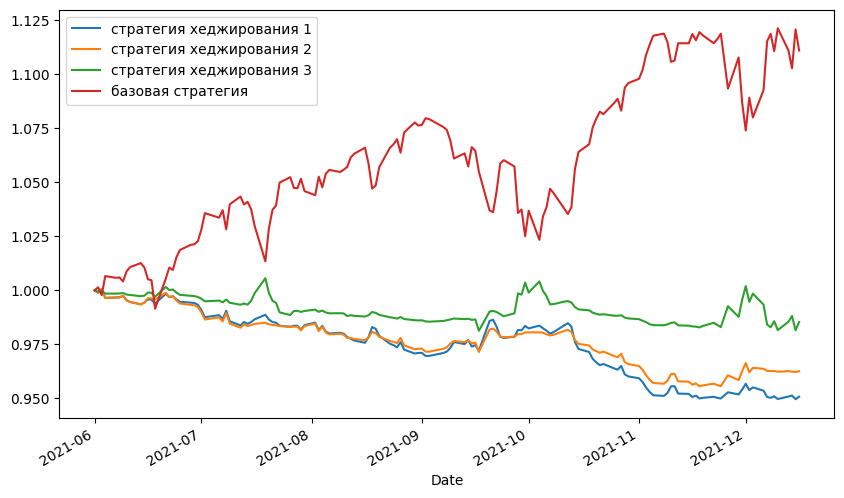

In [ ]:
snp_mod_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)
snp_mod_123b.plot(figsize=(10,6))

<Axes: xlabel='Date'>

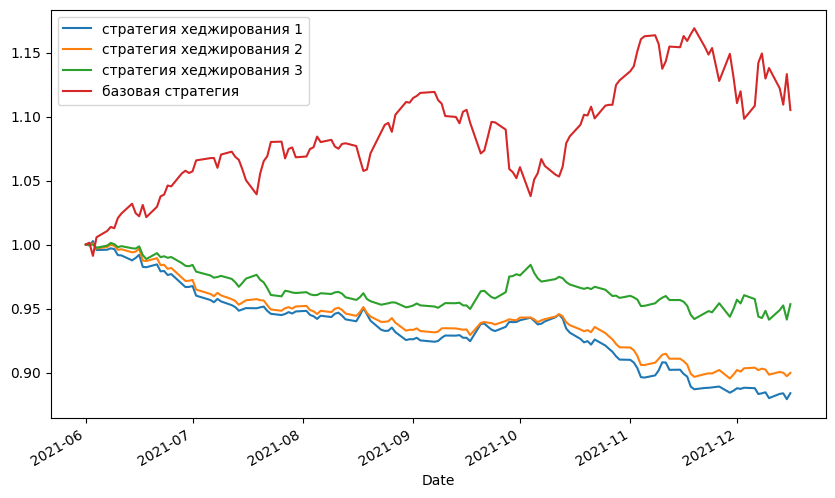

In [ ]:
nq_mod_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)
nq_mod_123b.plot(figsize=(10,6))

<Axes: xlabel='Date'>

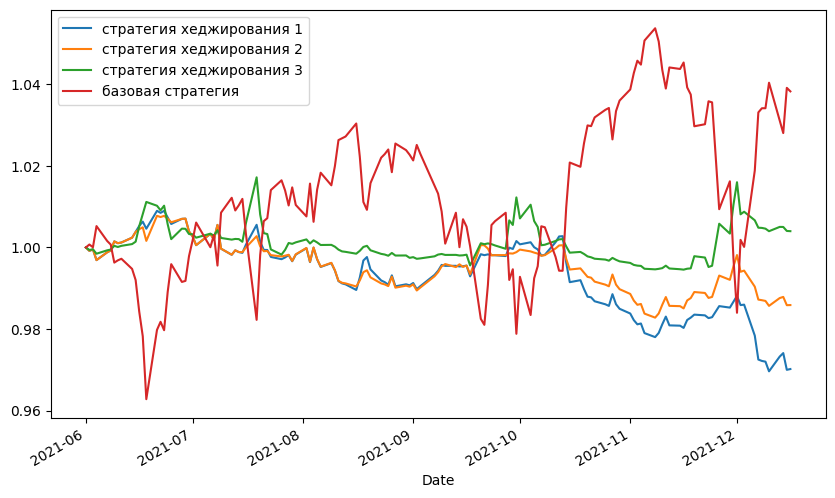

In [ ]:
dj_mod_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)

dj_mod_123b.plot(figsize=(10,6))

In [ ]:
snp_test_12 = pd.merge(snp_test_1, snp_test_2, how='inner', right_index = True, left_index = True)
snp_test_123 = pd.merge(snp_test_12, snp_test_3, how='inner', right_index = True, left_index = True)
snp_test_123b = pd.merge(snp_test_123, snp_test_b, how='inner', right_index = True, left_index = True)

nq_test_12 = pd.merge(nq_test_1, nq_test_2, how='inner', right_index = True, left_index = True)
nq_test_123 = pd.merge(nq_test_12, nq_test_3, how='inner', right_index = True, left_index = True)
nq_test_123b = pd.merge(nq_test_123, nq_test_b, how='inner', right_index = True, left_index = True)

dj_test_12 = pd.merge(dj_test_1, dj_test_2, how='inner', right_index = True, left_index = True)
dj_test_123 = pd.merge(dj_test_12, dj_test_3, how='inner', right_index = True, left_index = True)
dj_test_123b = pd.merge(dj_test_123, dj_test_b, how='inner', right_index = True, left_index = True)

<Axes: xlabel='Date'>

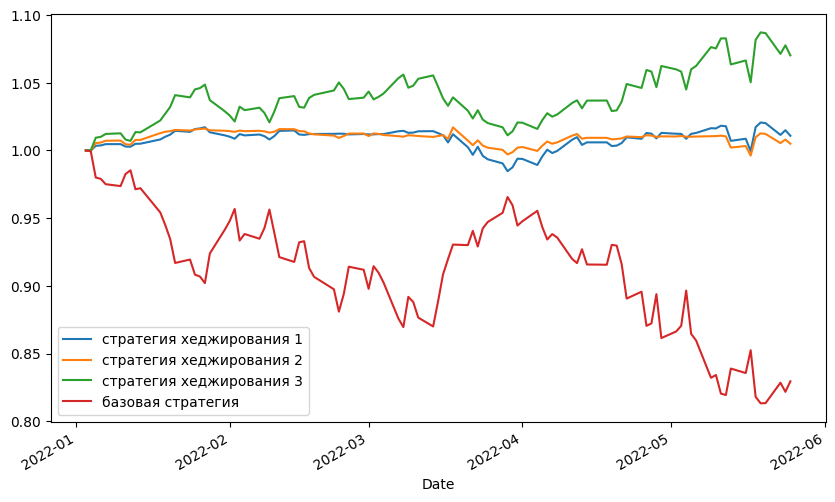

In [ ]:
snp_test_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)

snp_test_123b.plot(figsize=(10,6))

<Axes: xlabel='Date'>

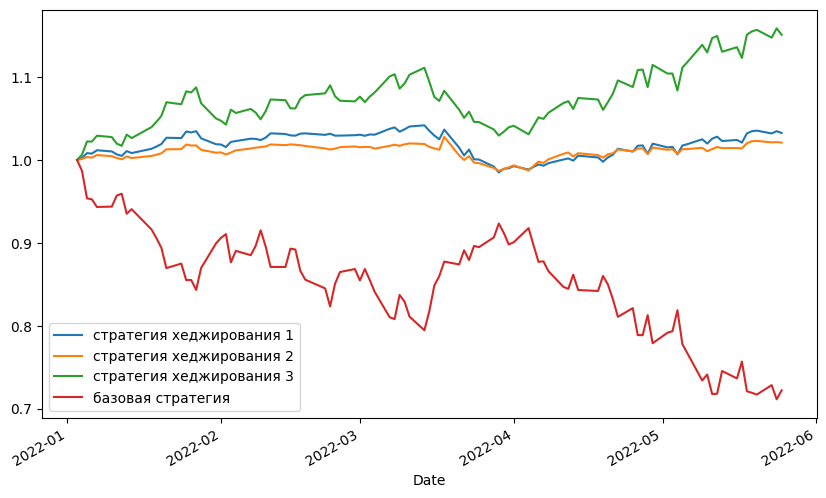

In [ ]:
nq_test_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)

nq_test_123b.plot(figsize=(10,6))

<Axes: xlabel='Date'>

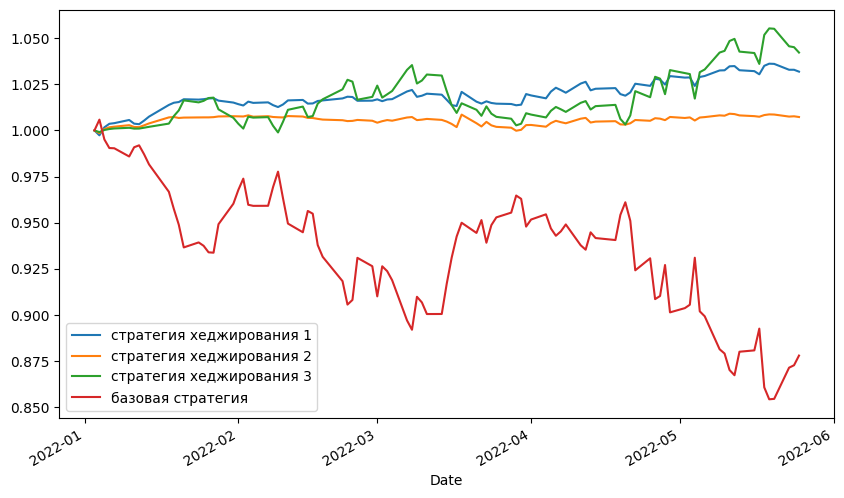

In [ ]:
dj_test_123b.rename(columns={'compod_daily_pct_str_1': 'стратегия хеджирования 1', 'compod_daily_pct_str_2': 'стратегия хеджирования 2', 'compod_daily_pct_str_3': 'стратегия хеджирования 3', 'compod_daily': 'базовая стратегия'}, inplace=True)

dj_test_123b.plot(figsize=(10,6))